In [85]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace


In [86]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [87]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [88]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [89]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [90]:

configs.data_name = data_name



In [91]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [92]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [93]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [94]:
data_name

'dd_fix_stats_demo'

In [95]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [96]:


data_name



'dd_fix_stats_demo'

In [97]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [98]:
df_data_to_use.shape

(9071, 15)

In [99]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [100]:

x_org.head()



,FIX_DURATION_mean,Grade_5,FIX_X_mean,FIX_Y_mean,Sex_1,Grade_4,IQ,Grade_3,FIX_DURATION_std,FIX_X_std,Sex_2,Grade_2,Age,FIX_Y_std,Grade_6,Grade_1,Word_Number
0,147.500000,0,645.693750,537.731250,1,1,23,0,78.438086,283.247212,0,0,10,5.683393,0,0,8
1,180.810811,0,644.781081,524.345946,1,1,23,0,88.588574,202.020928,0,0,10,8.486152,0,0,8
2,187.961538,0,708.334615,536.546154,1,1,23,0,130.054290,292.435973,0,0,10,7.099140,0,0,9
3,179.761905,0,676.047619,535.933333,1,1,23,0,73.502996,317.074279,0,0,10,6.465627,0,0,8
4,201.800000,0,440.215000,541.580000,1,1,23,0,91.100638,235.935556,0,0,10,5.290667,0,0,8


In [101]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [102]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [103]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [20]:

# data = dd.get_stratified_train_test_splits(
#         x=x, y=y,
#         labels=y_org.Group.values,
#         to_shuffle=to_shuffle,
#         n_splits=10
#     )



# for k, v in data.items():
#     print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

## Load the tuned parameters

In [21]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [22]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [23]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [24]:

# n_s = str(6)
# x_train = data[n_s]["x_train"]
# x_test = data[n_s]["x_test"]
# y_train = data[n_s]["y_train"]
# y_test = data[n_s]["y_test"]


# Using the entire set to train the model, cause we have independent test
idx = np.random.permutation(len(x))

x_train = x[idx, :]
y_train = y[idx]



In [25]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

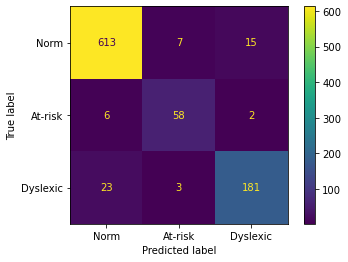

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


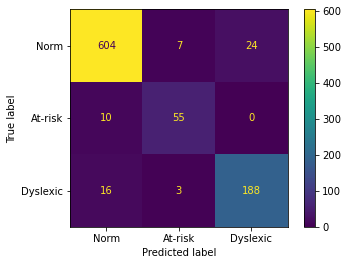

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


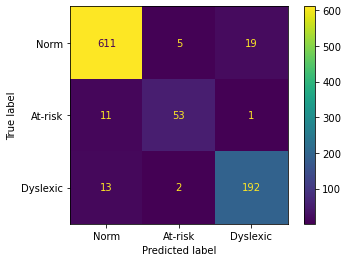

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


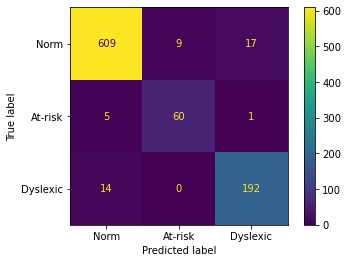

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


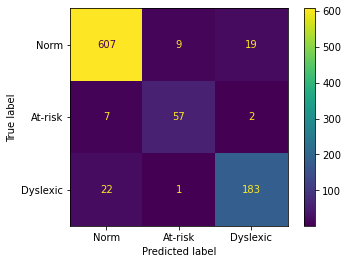

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


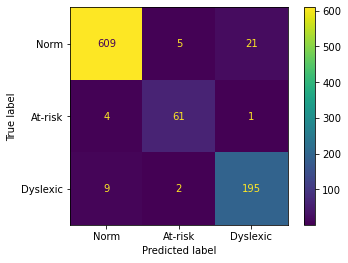

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


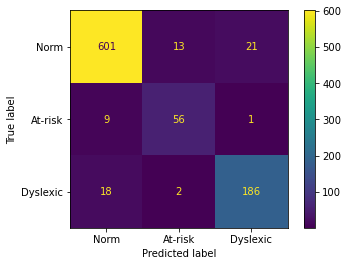

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


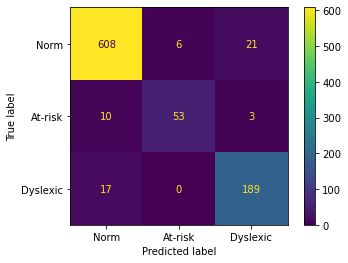

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


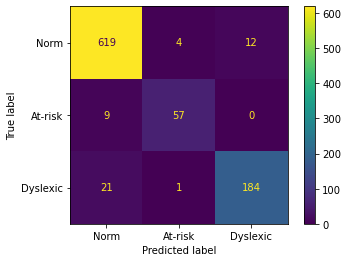

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


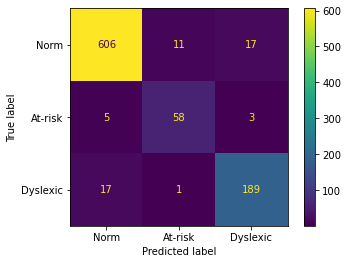

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [26]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [27]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.076 0.090 0.088 0.005 0.941 0.007 0.929 0.013


In [28]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83253D-01    |proj g|=  2.92434D-01

At iterate    1    f=  8.04013D-01    |proj g|=  6.29255D-02

At iterate    2    f=  7.79826D-01    |proj g|=  4.38884D-02

At iterate    3    f=  7.33708D-01    |proj g|=  3.30264D-02

At iterate    4    f=  7.24335D-01    |proj g|=  1.54163D-02

At iterate    5    f=  7.14562D-01    |proj g|=  2.11613D-02

At iterate    6    f=  7.04987D-01    |proj g|=  1.94954D-02

At iterate    7    f=  6.84798D-01    |proj g|=  1.06549D-02

At iterate    8    f=  6.72830D-01    |proj g|=  2.68374D-02

At iterate    9    f=  6.57242D-01    |proj g|=  1.54668D-02

At iterate   10    f=  6.40823D-01    |proj g|=  2.03928D-02

At iterate   11    f=  6.35964D-01    |proj g|=  5.10659D-02

At iterate   12    f=  6.29964D-01    |proj g|=  1.51869D-02


 This problem is unconstrained.



At iterate   13    f=  6.28302D-01    |proj g|=  1.44570D-02

At iterate   14    f=  6.25622D-01    |proj g|=  1.72023D-02

At iterate   15    f=  6.20463D-01    |proj g|=  1.53258D-02

At iterate   16    f=  6.13196D-01    |proj g|=  1.36991D-02

At iterate   17    f=  6.06081D-01    |proj g|=  1.39741D-02

At iterate   18    f=  6.03465D-01    |proj g|=  1.51126D-02

At iterate   19    f=  6.01498D-01    |proj g|=  1.33415D-02

At iterate   20    f=  6.00280D-01    |proj g|=  1.03013D-02

At iterate   21    f=  5.98060D-01    |proj g|=  6.89426D-03

At iterate   22    f=  5.95483D-01    |proj g|=  7.53172D-03

At iterate   23    f=  5.92319D-01    |proj g|=  5.45226D-03

At iterate   24    f=  5.88974D-01    |proj g|=  2.12226D-02

At iterate   25    f=  5.86237D-01    |proj g|=  1.17041D-02

At iterate   26    f=  5.83347D-01    |proj g|=  1.31190D-02

At iterate   27    f=  5.80507D-01    |proj g|=  1.28153D-02

At iterate   28    f=  5.78760D-01    |proj g|=  2.24458D-02

At iter


At iterate  149    f=  4.12589D-01    |proj g|=  6.64279D-03

At iterate  150    f=  4.11773D-01    |proj g|=  5.57361D-03

At iterate  151    f=  4.10614D-01    |proj g|=  8.19705D-03

At iterate  152    f=  4.09609D-01    |proj g|=  1.27558D-02

At iterate  153    f=  4.08522D-01    |proj g|=  1.29495D-02

At iterate  154    f=  4.07529D-01    |proj g|=  8.40506D-03

At iterate  155    f=  4.06044D-01    |proj g|=  7.20723D-03

At iterate  156    f=  4.05006D-01    |proj g|=  2.73896D-02

At iterate  157    f=  4.03501D-01    |proj g|=  9.39728D-03

At iterate  158    f=  4.02772D-01    |proj g|=  1.02758D-02

At iterate  159    f=  4.02168D-01    |proj g|=  1.04352D-02

At iterate  160    f=  4.00874D-01    |proj g|=  7.68704D-03

At iterate  161    f=  3.99659D-01    |proj g|=  1.58383D-02

At iterate  162    f=  3.98931D-01    |proj g|=  1.40995D-02

At iterate  163    f=  3.98061D-01    |proj g|=  5.82344D-03

At iterate  164    f=  3.97606D-01    |proj g|=  5.70012D-03

At iter


At iterate  295    f=  2.96745D-01    |proj g|=  1.50225D-02

At iterate  296    f=  2.95993D-01    |proj g|=  7.35012D-03

At iterate  297    f=  2.94693D-01    |proj g|=  6.14780D-03

At iterate  298    f=  2.93734D-01    |proj g|=  6.72657D-03

At iterate  299    f=  2.92282D-01    |proj g|=  7.69747D-03

At iterate  300    f=  2.91743D-01    |proj g|=  6.09263D-03

At iterate  301    f=  2.91267D-01    |proj g|=  4.42023D-03

At iterate  302    f=  2.90645D-01    |proj g|=  7.89883D-03

At iterate  303    f=  2.90471D-01    |proj g|=  1.55153D-02

At iterate  304    f=  2.90017D-01    |proj g|=  4.91677D-03

At iterate  305    f=  2.89821D-01    |proj g|=  3.93638D-03

At iterate  306    f=  2.89590D-01    |proj g|=  5.90670D-03

At iterate  307    f=  2.89069D-01    |proj g|=  6.89524D-03

At iterate  308    f=  2.88762D-01    |proj g|=  1.11356D-02

At iterate  309    f=  2.87997D-01    |proj g|=  7.23917D-03

At iterate  310    f=  2.87375D-01    |proj g|=  4.85371D-03

At iter


At iterate  436    f=  2.29818D-01    |proj g|=  7.12641D-03

At iterate  437    f=  2.29412D-01    |proj g|=  3.98408D-03

At iterate  438    f=  2.29111D-01    |proj g|=  3.82866D-03

At iterate  439    f=  2.28776D-01    |proj g|=  4.20154D-03

At iterate  440    f=  2.28575D-01    |proj g|=  9.75121D-03

At iterate  441    f=  2.28228D-01    |proj g|=  5.32410D-03

At iterate  442    f=  2.27955D-01    |proj g|=  3.07229D-03

At iterate  443    f=  2.27917D-01    |proj g|=  1.74168D-02

At iterate  444    f=  2.27619D-01    |proj g|=  4.23852D-03

At iterate  445    f=  2.27552D-01    |proj g|=  3.70433D-03

At iterate  446    f=  2.27367D-01    |proj g|=  4.62276D-03

At iterate  447    f=  2.27102D-01    |proj g|=  4.38825D-03

At iterate  448    f=  2.26657D-01    |proj g|=  1.02252D-02

At iterate  449    f=  2.26083D-01    |proj g|=  6.09224D-03

At iterate  450    f=  2.25696D-01    |proj g|=  4.20628D-03

At iterate  451    f=  2.25352D-01    |proj g|=  1.01170D-02

At iter


At iterate  569    f=  2.04156D-01    |proj g|=  1.12439D-02

At iterate  570    f=  2.03976D-01    |proj g|=  3.47448D-03

At iterate  571    f=  2.03937D-01    |proj g|=  2.95197D-03

At iterate  572    f=  2.03826D-01    |proj g|=  1.99991D-03

At iterate  573    f=  2.03678D-01    |proj g|=  3.47319D-03

At iterate  574    f=  2.03565D-01    |proj g|=  4.48263D-03

At iterate  575    f=  2.03411D-01    |proj g|=  2.81832D-03

At iterate  576    f=  2.03244D-01    |proj g|=  2.52862D-03

At iterate  577    f=  2.03050D-01    |proj g|=  2.06586D-03

At iterate  578    f=  2.03006D-01    |proj g|=  4.97585D-03

At iterate  579    f=  2.02866D-01    |proj g|=  3.49609D-03

At iterate  580    f=  2.02707D-01    |proj g|=  2.16930D-03

At iterate  581    f=  2.02465D-01    |proj g|=  5.09093D-03

At iterate  582    f=  2.02409D-01    |proj g|=  3.32771D-03

At iterate  583    f=  2.02344D-01    |proj g|=  2.44930D-03

At iterate  584    f=  2.02231D-01    |proj g|=  2.11363D-03

At iter


At iterate  705    f=  1.86109D-01    |proj g|=  3.07228D-03

At iterate  706    f=  1.86024D-01    |proj g|=  3.26804D-03

At iterate  707    f=  1.85928D-01    |proj g|=  6.35222D-03

At iterate  708    f=  1.85804D-01    |proj g|=  3.39081D-03

At iterate  709    f=  1.85687D-01    |proj g|=  3.32776D-03

At iterate  710    f=  1.85451D-01    |proj g|=  2.69003D-03

At iterate  711    f=  1.85282D-01    |proj g|=  4.86876D-03

At iterate  712    f=  1.85073D-01    |proj g|=  7.16700D-03

At iterate  713    f=  1.84903D-01    |proj g|=  3.45695D-03

At iterate  714    f=  1.84767D-01    |proj g|=  2.96532D-03

At iterate  715    f=  1.84618D-01    |proj g|=  3.37842D-03

At iterate  716    f=  1.84362D-01    |proj g|=  5.98494D-03

At iterate  717    f=  1.84255D-01    |proj g|=  3.50358D-03

At iterate  718    f=  1.84160D-01    |proj g|=  3.34141D-03

At iterate  719    f=  1.83924D-01    |proj g|=  2.61886D-03

At iterate  720    f=  1.83679D-01    |proj g|=  3.82468D-03

At iter


At iterate  846    f=  1.68644D-01    |proj g|=  5.93070D-03

At iterate  847    f=  1.68565D-01    |proj g|=  2.29119D-03

At iterate  848    f=  1.68505D-01    |proj g|=  2.46401D-03

At iterate  849    f=  1.68422D-01    |proj g|=  4.64302D-03

At iterate  850    f=  1.68340D-01    |proj g|=  7.62059D-03

At iterate  851    f=  1.68248D-01    |proj g|=  2.62220D-03

At iterate  852    f=  1.68177D-01    |proj g|=  2.71656D-03

At iterate  853    f=  1.68115D-01    |proj g|=  3.60403D-03

At iterate  854    f=  1.68000D-01    |proj g|=  5.79964D-03

At iterate  855    f=  1.67918D-01    |proj g|=  5.87523D-03

At iterate  856    f=  1.67847D-01    |proj g|=  2.54996D-03

At iterate  857    f=  1.67773D-01    |proj g|=  3.72034D-03

At iterate  858    f=  1.67688D-01    |proj g|=  4.55581D-03

At iterate  859    f=  1.67514D-01    |proj g|=  6.15902D-03

At iterate  860    f=  1.67450D-01    |proj g|=  4.70791D-03

At iterate  861    f=  1.67360D-01    |proj g|=  2.19358D-03

At iter

At iterate  982    f=  1.57704D-01    |proj g|=  4.94448D-03

At iterate  983    f=  1.57661D-01    |proj g|=  3.06811D-03

At iterate  984    f=  1.57594D-01    |proj g|=  1.79611D-03

At iterate  985    f=  1.57549D-01    |proj g|=  3.87967D-03

At iterate  986    f=  1.57458D-01    |proj g|=  2.40452D-03

At iterate  987    f=  1.57379D-01    |proj g|=  6.55662D-03

At iterate  988    f=  1.57307D-01    |proj g|=  2.54450D-03

At iterate  989    f=  1.57256D-01    |proj g|=  1.99743D-03

At iterate  990    f=  1.57222D-01    |proj g|=  2.42463D-03

At iterate  991    f=  1.57118D-01    |proj g|=  2.85412D-03

At iterate  992    f=  1.56997D-01    |proj g|=  6.18523D-03

At iterate  993    f=  1.56865D-01    |proj g|=  3.70523D-03

At iterate  994    f=  1.56778D-01    |proj g|=  2.13540D-03

At iterate  995    f=  1.56715D-01    |proj g|=  8.42107D-03

At iterate  996    f=  1.56665D-01    |proj g|=  3.12761D-03

At iterate  997    f=  1.56628D-01    |proj g|=  2.60652D-03

At itera


At iterate 1124    f=  1.49243D-01    |proj g|=  2.95514D-03

At iterate 1125    f=  1.49188D-01    |proj g|=  7.31243D-03

At iterate 1126    f=  1.49137D-01    |proj g|=  2.68839D-03

At iterate 1127    f=  1.49095D-01    |proj g|=  2.43124D-03

At iterate 1128    f=  1.49026D-01    |proj g|=  2.68952D-03

At iterate 1129    f=  1.48982D-01    |proj g|=  2.67765D-03

At iterate 1130    f=  1.48949D-01    |proj g|=  2.61776D-03

At iterate 1131    f=  1.48906D-01    |proj g|=  2.27883D-03

At iterate 1132    f=  1.48833D-01    |proj g|=  1.75462D-03

At iterate 1133    f=  1.48762D-01    |proj g|=  3.35844D-03

At iterate 1134    f=  1.48696D-01    |proj g|=  2.73994D-03

At iterate 1135    f=  1.48646D-01    |proj g|=  2.38701D-03

At iterate 1136    f=  1.48588D-01    |proj g|=  2.31970D-03

At iterate 1137    f=  1.48516D-01    |proj g|=  2.88370D-03

At iterate 1138    f=  1.48475D-01    |proj g|=  1.42532D-02

At iterate 1139    f=  1.48379D-01    |proj g|=  3.58231D-03

At iter


At iterate 1260    f=  1.43804D-01    |proj g|=  1.43788D-03

At iterate 1261    f=  1.43742D-01    |proj g|=  2.81516D-03

At iterate 1262    f=  1.43728D-01    |proj g|=  3.81124D-03

At iterate 1263    f=  1.43707D-01    |proj g|=  1.82407D-03

At iterate 1264    f=  1.43683D-01    |proj g|=  1.02244D-03

At iterate 1265    f=  1.43658D-01    |proj g|=  1.74605D-03

At iterate 1266    f=  1.43635D-01    |proj g|=  5.55763D-03

At iterate 1267    f=  1.43607D-01    |proj g|=  2.40369D-03

At iterate 1268    f=  1.43592D-01    |proj g|=  1.33453D-03

At iterate 1269    f=  1.43573D-01    |proj g|=  1.52964D-03

At iterate 1270    f=  1.43553D-01    |proj g|=  4.09347D-03

At iterate 1271    f=  1.43526D-01    |proj g|=  2.66584D-03

At iterate 1272    f=  1.43501D-01    |proj g|=  1.59849D-03

At iterate 1273    f=  1.43465D-01    |proj g|=  1.75317D-03

At iterate 1274    f=  1.43426D-01    |proj g|=  2.39687D-03

At iterate 1275    f=  1.43387D-01    |proj g|=  4.32203D-03

At iter


At iterate 1399    f=  1.39954D-01    |proj g|=  2.17972D-03

At iterate 1400    f=  1.39921D-01    |proj g|=  7.07188D-03

At iterate 1401    f=  1.39858D-01    |proj g|=  1.96061D-03

At iterate 1402    f=  1.39827D-01    |proj g|=  1.10753D-03

At iterate 1403    f=  1.39806D-01    |proj g|=  1.95778D-03

At iterate 1404    f=  1.39789D-01    |proj g|=  4.29370D-03

At iterate 1405    f=  1.39766D-01    |proj g|=  2.04257D-03

At iterate 1406    f=  1.39732D-01    |proj g|=  1.78733D-03

At iterate 1407    f=  1.39716D-01    |proj g|=  7.19870D-03

At iterate 1408    f=  1.39694D-01    |proj g|=  3.85674D-03

At iterate 1409    f=  1.39671D-01    |proj g|=  1.61223D-03

At iterate 1410    f=  1.39656D-01    |proj g|=  1.65931D-03

At iterate 1411    f=  1.39619D-01    |proj g|=  2.86351D-03

At iterate 1412    f=  1.39568D-01    |proj g|=  2.91343D-03

At iterate 1413    f=  1.39543D-01    |proj g|=  2.97848D-03

At iterate 1414    f=  1.39511D-01    |proj g|=  1.35571D-03

At iter


At iterate 1539    f=  1.36289D-01    |proj g|=  1.50165D-03

At iterate 1540    f=  1.36268D-01    |proj g|=  5.56011D-03

At iterate 1541    f=  1.36248D-01    |proj g|=  3.41159D-03

At iterate 1542    f=  1.36235D-01    |proj g|=  2.06580D-03

At iterate 1543    f=  1.36214D-01    |proj g|=  1.50822D-03

At iterate 1544    f=  1.36194D-01    |proj g|=  2.47944D-03

At iterate 1545    f=  1.36154D-01    |proj g|=  4.19338D-03

At iterate 1546    f=  1.36126D-01    |proj g|=  3.78132D-03

At iterate 1547    f=  1.36083D-01    |proj g|=  2.57924D-03

At iterate 1548    f=  1.36040D-01    |proj g|=  1.42291D-03

At iterate 1549    f=  1.36006D-01    |proj g|=  2.43509D-03

At iterate 1550    f=  1.35982D-01    |proj g|=  5.56381D-03

At iterate 1551    f=  1.35957D-01    |proj g|=  3.77097D-03

At iterate 1552    f=  1.35922D-01    |proj g|=  1.25624D-03

At iterate 1553    f=  1.35919D-01    |proj g|=  6.65987D-03

At iterate 1554    f=  1.35907D-01    |proj g|=  2.57600D-03

At iter


At iterate 1677    f=  1.31387D-01    |proj g|=  1.67996D-03

At iterate 1678    f=  1.31342D-01    |proj g|=  2.07141D-03

At iterate 1679    f=  1.31304D-01    |proj g|=  2.54906D-03

At iterate 1680    f=  1.31278D-01    |proj g|=  4.58369D-03

At iterate 1681    f=  1.31243D-01    |proj g|=  2.30818D-03

At iterate 1682    f=  1.31206D-01    |proj g|=  2.96789D-03

At iterate 1683    f=  1.31173D-01    |proj g|=  4.07392D-03

At iterate 1684    f=  1.31136D-01    |proj g|=  5.54843D-03

At iterate 1685    f=  1.31107D-01    |proj g|=  3.94742D-03

At iterate 1686    f=  1.31070D-01    |proj g|=  1.72088D-03

At iterate 1687    f=  1.31054D-01    |proj g|=  2.34335D-03

At iterate 1688    f=  1.31024D-01    |proj g|=  4.47415D-03

At iterate 1689    f=  1.30991D-01    |proj g|=  2.46178D-03

At iterate 1690    f=  1.30967D-01    |proj g|=  2.64633D-03

At iterate 1691    f=  1.30919D-01    |proj g|=  3.86135D-03

At iterate 1692    f=  1.30875D-01    |proj g|=  4.53783D-03

At iter


At iterate 1816    f=  1.25703D-01    |proj g|=  2.87519D-03

At iterate 1817    f=  1.25668D-01    |proj g|=  1.77478D-03

At iterate 1818    f=  1.25625D-01    |proj g|=  2.34860D-03

At iterate 1819    f=  1.25605D-01    |proj g|=  4.58729D-03

At iterate 1820    f=  1.25582D-01    |proj g|=  2.62838D-03

At iterate 1821    f=  1.25556D-01    |proj g|=  1.68925D-03

At iterate 1822    f=  1.25539D-01    |proj g|=  1.98895D-03

At iterate 1823    f=  1.25515D-01    |proj g|=  7.21033D-03

At iterate 1824    f=  1.25482D-01    |proj g|=  2.87251D-03

At iterate 1825    f=  1.25442D-01    |proj g|=  3.24261D-03

At iterate 1826    f=  1.25426D-01    |proj g|=  2.80336D-03

At iterate 1827    f=  1.25381D-01    |proj g|=  5.13447D-03

At iterate 1828    f=  1.25351D-01    |proj g|=  3.94604D-03

At iterate 1829    f=  1.25324D-01    |proj g|=  2.10516D-03

At iterate 1830    f=  1.25294D-01    |proj g|=  2.13836D-03

At iterate 1831    f=  1.25262D-01    |proj g|=  1.99909D-03

At iter


At iterate 1954    f=  1.22036D-01    |proj g|=  2.14428D-03

At iterate 1955    f=  1.22020D-01    |proj g|=  7.91047D-03

At iterate 1956    f=  1.21998D-01    |proj g|=  3.90931D-03

At iterate 1957    f=  1.21964D-01    |proj g|=  2.07268D-03

At iterate 1958    f=  1.21949D-01    |proj g|=  2.38988D-03

At iterate 1959    f=  1.21917D-01    |proj g|=  1.83931D-03

At iterate 1960    f=  1.21906D-01    |proj g|=  3.26156D-03

At iterate 1961    f=  1.21889D-01    |proj g|=  1.30293D-03

At iterate 1962    f=  1.21876D-01    |proj g|=  1.23410D-03

At iterate 1963    f=  1.21848D-01    |proj g|=  2.64708D-03

At iterate 1964    f=  1.21814D-01    |proj g|=  4.60718D-03

At iterate 1965    f=  1.21787D-01    |proj g|=  5.42008D-03

At iterate 1966    f=  1.21755D-01    |proj g|=  1.80028D-03

At iterate 1967    f=  1.21733D-01    |proj g|=  1.45902D-03

At iterate 1968    f=  1.21712D-01    |proj g|=  5.19452D-03

At iterate 1969    f=  1.21694D-01    |proj g|=  2.12806D-03

At iter


At iterate 2087    f=  1.19539D-01    |proj g|=  3.75285D-03

At iterate 2088    f=  1.19516D-01    |proj g|=  1.82738D-03

At iterate 2089    f=  1.19484D-01    |proj g|=  2.10814D-03

At iterate 2090    f=  1.19455D-01    |proj g|=  2.53600D-03

At iterate 2091    f=  1.19440D-01    |proj g|=  4.95718D-03

At iterate 2092    f=  1.19417D-01    |proj g|=  2.12658D-03

At iterate 2093    f=  1.19396D-01    |proj g|=  1.43798D-03

At iterate 2094    f=  1.19376D-01    |proj g|=  2.40441D-03

At iterate 2095    f=  1.19355D-01    |proj g|=  4.61823D-03

At iterate 2096    f=  1.19344D-01    |proj g|=  4.13579D-03

At iterate 2097    f=  1.19332D-01    |proj g|=  1.42926D-03

At iterate 2098    f=  1.19324D-01    |proj g|=  1.07908D-03

At iterate 2099    f=  1.19311D-01    |proj g|=  2.72164D-03

At iterate 2100    f=  1.19288D-01    |proj g|=  3.82149D-03

At iterate 2101    f=  1.19265D-01    |proj g|=  5.91785D-03

At iterate 2102    f=  1.19244D-01    |proj g|=  2.22823D-03

At iter

At iterate 2237    f=  1.15850D-01    |proj g|=  3.78084D-03

At iterate 2238    f=  1.15827D-01    |proj g|=  2.71717D-03

At iterate 2239    f=  1.15779D-01    |proj g|=  2.17012D-03

At iterate 2240    f=  1.15743D-01    |proj g|=  1.80094D-03

At iterate 2241    f=  1.15709D-01    |proj g|=  5.78737D-03

At iterate 2242    f=  1.15671D-01    |proj g|=  3.04670D-03

At iterate 2243    f=  1.15651D-01    |proj g|=  1.68085D-03

At iterate 2244    f=  1.15615D-01    |proj g|=  1.97879D-03

At iterate 2245    f=  1.15586D-01    |proj g|=  2.71913D-03

At iterate 2246    f=  1.15567D-01    |proj g|=  6.69545D-03

At iterate 2247    f=  1.15537D-01    |proj g|=  3.57261D-03

At iterate 2248    f=  1.15511D-01    |proj g|=  1.72950D-03

At iterate 2249    f=  1.15491D-01    |proj g|=  8.62953D-03

At iterate 2250    f=  1.15467D-01    |proj g|=  2.43109D-03

At iterate 2251    f=  1.15453D-01    |proj g|=  1.59691D-03

At iterate 2252    f=  1.15434D-01    |proj g|=  2.11102D-03

At itera


At iterate 2370    f=  1.11930D-01    |proj g|=  2.27099D-03

At iterate 2371    f=  1.11886D-01    |proj g|=  2.48533D-03

At iterate 2372    f=  1.11857D-01    |proj g|=  5.08745D-03

At iterate 2373    f=  1.11827D-01    |proj g|=  2.92480D-03

At iterate 2374    f=  1.11807D-01    |proj g|=  2.22877D-03

At iterate 2375    f=  1.11772D-01    |proj g|=  1.92329D-03

At iterate 2376    f=  1.11735D-01    |proj g|=  1.92628D-03

At iterate 2377    f=  1.11713D-01    |proj g|=  7.73619D-03

At iterate 2378    f=  1.11677D-01    |proj g|=  2.30991D-03

At iterate 2379    f=  1.11660D-01    |proj g|=  1.37798D-03

At iterate 2380    f=  1.11642D-01    |proj g|=  1.59286D-03

At iterate 2381    f=  1.11622D-01    |proj g|=  3.59367D-03

At iterate 2382    f=  1.11598D-01    |proj g|=  1.99955D-03

At iterate 2383    f=  1.11566D-01    |proj g|=  1.27182D-03

At iterate 2384    f=  1.11543D-01    |proj g|=  3.03618D-03

At iterate 2385    f=  1.11513D-01    |proj g|=  5.31420D-03

At iter


At iterate 2506    f=  1.08440D-01    |proj g|=  2.05723D-03

At iterate 2507    f=  1.08423D-01    |proj g|=  3.40162D-03

At iterate 2508    f=  1.08395D-01    |proj g|=  2.02794D-03

At iterate 2509    f=  1.08379D-01    |proj g|=  1.76552D-03

At iterate 2510    f=  1.08362D-01    |proj g|=  1.84558D-03

At iterate 2511    f=  1.08331D-01    |proj g|=  2.42269D-03

At iterate 2512    f=  1.08274D-01    |proj g|=  2.13885D-03

At iterate 2513    f=  1.08250D-01    |proj g|=  6.40477D-03

At iterate 2514    f=  1.08205D-01    |proj g|=  2.28565D-03

At iterate 2515    f=  1.08184D-01    |proj g|=  2.16626D-03

At iterate 2516    f=  1.08165D-01    |proj g|=  3.28222D-03

At iterate 2517    f=  1.08148D-01    |proj g|=  3.03683D-03

At iterate 2518    f=  1.08070D-01    |proj g|=  2.65603D-03

At iterate 2519    f=  1.08051D-01    |proj g|=  6.99505D-03

At iterate 2520    f=  1.08012D-01    |proj g|=  2.37163D-03

At iterate 2521    f=  1.07984D-01    |proj g|=  1.93844D-03

At iter


At iterate 2639    f=  1.04954D-01    |proj g|=  3.98046D-03

At iterate 2640    f=  1.04924D-01    |proj g|=  5.54200D-03

At iterate 2641    f=  1.04872D-01    |proj g|=  5.51066D-03

At iterate 2642    f=  1.04838D-01    |proj g|=  9.34258D-03

At iterate 2643    f=  1.04808D-01    |proj g|=  4.00885D-03

At iterate 2644    f=  1.04791D-01    |proj g|=  3.07720D-03

At iterate 2645    f=  1.04769D-01    |proj g|=  2.54927D-03

At iterate 2646    f=  1.04735D-01    |proj g|=  2.64269D-03

At iterate 2647    f=  1.04687D-01    |proj g|=  1.99026D-03

At iterate 2648    f=  1.04673D-01    |proj g|=  8.41887D-03

At iterate 2649    f=  1.04636D-01    |proj g|=  1.72372D-03

At iterate 2650    f=  1.04623D-01    |proj g|=  1.33399D-03

At iterate 2651    f=  1.04606D-01    |proj g|=  3.86398D-03

At iterate 2652    f=  1.04588D-01    |proj g|=  2.55050D-03

At iterate 2653    f=  1.04570D-01    |proj g|=  1.94383D-03

At iterate 2654    f=  1.04544D-01    |proj g|=  5.83115D-03

At iter


At iterate 2780    f=  1.01157D-01    |proj g|=  3.51838D-03

At iterate 2781    f=  1.01136D-01    |proj g|=  6.91869D-03

At iterate 2782    f=  1.01101D-01    |proj g|=  2.90682D-03

At iterate 2783    f=  1.01084D-01    |proj g|=  2.68558D-03

At iterate 2784    f=  1.01067D-01    |proj g|=  4.38046D-03

At iterate 2785    f=  1.01045D-01    |proj g|=  2.21803D-03

At iterate 2786    f=  1.01026D-01    |proj g|=  2.28696D-03

At iterate 2787    f=  1.00991D-01    |proj g|=  2.45980D-03

At iterate 2788    f=  1.00976D-01    |proj g|=  5.16296D-03

At iterate 2789    f=  1.00945D-01    |proj g|=  4.00077D-03

At iterate 2790    f=  1.00910D-01    |proj g|=  2.06562D-03

At iterate 2791    f=  1.00888D-01    |proj g|=  1.81869D-03

At iterate 2792    f=  1.00864D-01    |proj g|=  2.32894D-03

At iterate 2793    f=  1.00832D-01    |proj g|=  5.12958D-03

At iterate 2794    f=  1.00803D-01    |proj g|=  2.49230D-03

At iterate 2795    f=  1.00783D-01    |proj g|=  2.51837D-03

At iter


At iterate 2916    f=  9.89280D-02    |proj g|=  3.47408D-03

At iterate 2917    f=  9.89102D-02    |proj g|=  1.97922D-03

At iterate 2918    f=  9.88944D-02    |proj g|=  3.35140D-03

At iterate 2919    f=  9.88760D-02    |proj g|=  2.90905D-03

At iterate 2920    f=  9.88595D-02    |proj g|=  4.26415D-03

At iterate 2921    f=  9.88381D-02    |proj g|=  2.04168D-03

At iterate 2922    f=  9.88304D-02    |proj g|=  1.62311D-03

At iterate 2923    f=  9.88105D-02    |proj g|=  1.75192D-03

At iterate 2924    f=  9.88004D-02    |proj g|=  4.95635D-03

At iterate 2925    f=  9.87814D-02    |proj g|=  3.30335D-03

At iterate 2926    f=  9.87601D-02    |proj g|=  1.19934D-03

At iterate 2927    f=  9.87465D-02    |proj g|=  2.31418D-03

At iterate 2928    f=  9.87356D-02    |proj g|=  2.99262D-03

At iterate 2929    f=  9.87251D-02    |proj g|=  6.26719D-03

At iterate 2930    f=  9.87123D-02    |proj g|=  2.49948D-03

At iterate 2931    f=  9.86974D-02    |proj g|=  1.76144D-03

At iter


At iterate 3056    f=  9.72422D-02    |proj g|=  1.31512D-03

At iterate 3057    f=  9.72388D-02    |proj g|=  8.89224D-04

At iterate 3058    f=  9.72324D-02    |proj g|=  9.52513D-04

At iterate 3059    f=  9.72233D-02    |proj g|=  3.94634D-03

At iterate 3060    f=  9.72146D-02    |proj g|=  3.01182D-03

At iterate 3061    f=  9.72089D-02    |proj g|=  1.71119D-03

At iterate 3062    f=  9.72024D-02    |proj g|=  1.01735D-03

At iterate 3063    f=  9.71954D-02    |proj g|=  1.59147D-03

At iterate 3064    f=  9.71786D-02    |proj g|=  2.49112D-03

At iterate 3065    f=  9.71611D-02    |proj g|=  3.47285D-03

At iterate 3066    f=  9.71512D-02    |proj g|=  3.77381D-03

At iterate 3067    f=  9.71415D-02    |proj g|=  2.52816D-03

At iterate 3068    f=  9.71373D-02    |proj g|=  1.14570D-03

At iterate 3069    f=  9.71343D-02    |proj g|=  1.15847D-03

At iterate 3070    f=  9.71237D-02    |proj g|=  1.29415D-03

At iterate 3071    f=  9.71103D-02    |proj g|=  1.61684D-03

At iter


At iterate 3202    f=  9.57938D-02    |proj g|=  2.91941D-03

At iterate 3203    f=  9.57742D-02    |proj g|=  5.00100D-03

At iterate 3204    f=  9.57632D-02    |proj g|=  2.66781D-03

At iterate 3205    f=  9.57550D-02    |proj g|=  1.60047D-03

At iterate 3206    f=  9.57448D-02    |proj g|=  1.49578D-03

At iterate 3207    f=  9.57327D-02    |proj g|=  2.20810D-03

At iterate 3208    f=  9.57252D-02    |proj g|=  1.06555D-02

At iterate 3209    f=  9.56928D-02    |proj g|=  3.17152D-03

At iterate 3210    f=  9.56788D-02    |proj g|=  1.16319D-03

At iterate 3211    f=  9.56672D-02    |proj g|=  2.75700D-03

At iterate 3212    f=  9.56604D-02    |proj g|=  6.20277D-03

At iterate 3213    f=  9.56507D-02    |proj g|=  2.92033D-03

At iterate 3214    f=  9.56380D-02    |proj g|=  1.60066D-03

At iterate 3215    f=  9.56317D-02    |proj g|=  2.29685D-03

At iterate 3216    f=  9.56122D-02    |proj g|=  3.02243D-03

At iterate 3217    f=  9.55997D-02    |proj g|=  4.52244D-03

At iter


At iterate 3338    f=  9.36481D-02    |proj g|=  4.11785D-03

At iterate 3339    f=  9.36347D-02    |proj g|=  2.04461D-03

At iterate 3340    f=  9.36243D-02    |proj g|=  1.65056D-03

At iterate 3341    f=  9.36164D-02    |proj g|=  2.43947D-03

At iterate 3342    f=  9.36082D-02    |proj g|=  2.29268D-03

At iterate 3343    f=  9.36004D-02    |proj g|=  1.56855D-03

At iterate 3344    f=  9.35820D-02    |proj g|=  2.35987D-03

At iterate 3345    f=  9.35686D-02    |proj g|=  1.82176D-03

At iterate 3346    f=  9.35546D-02    |proj g|=  3.02040D-03

At iterate 3347    f=  9.35410D-02    |proj g|=  2.02296D-03

At iterate 3348    f=  9.35225D-02    |proj g|=  3.29724D-03

At iterate 3349    f=  9.35095D-02    |proj g|=  4.20423D-03

At iterate 3350    f=  9.34987D-02    |proj g|=  4.49069D-03

At iterate 3351    f=  9.34835D-02    |proj g|=  1.63158D-03

At iterate 3352    f=  9.34759D-02    |proj g|=  1.55356D-03

At iterate 3353    f=  9.34591D-02    |proj g|=  3.58883D-03

At iter


At iterate 3473    f=  9.16413D-02    |proj g|=  1.52915D-03

At iterate 3474    f=  9.16181D-02    |proj g|=  1.31836D-03

At iterate 3475    f=  9.16137D-02    |proj g|=  4.18340D-03

At iterate 3476    f=  9.16037D-02    |proj g|=  3.34335D-03

At iterate 3477    f=  9.15838D-02    |proj g|=  1.42182D-03

At iterate 3478    f=  9.15748D-02    |proj g|=  1.15638D-03

At iterate 3479    f=  9.15650D-02    |proj g|=  2.62210D-03

At iterate 3480    f=  9.15505D-02    |proj g|=  1.79550D-03

At iterate 3481    f=  9.15285D-02    |proj g|=  4.02620D-03

At iterate 3482    f=  9.15166D-02    |proj g|=  1.87080D-03

At iterate 3483    f=  9.15110D-02    |proj g|=  1.65503D-03

At iterate 3484    f=  9.15062D-02    |proj g|=  6.39998D-03

At iterate 3485    f=  9.14897D-02    |proj g|=  2.04351D-03

At iterate 3486    f=  9.14808D-02    |proj g|=  1.74381D-03

At iterate 3487    f=  9.14659D-02    |proj g|=  2.55607D-03

At iterate 3488    f=  9.14513D-02    |proj g|=  4.01474D-03

At iter


At iterate 3617    f=  9.00416D-02    |proj g|=  1.78583D-03

At iterate 3618    f=  9.00258D-02    |proj g|=  3.02114D-03

At iterate 3619    f=  9.00144D-02    |proj g|=  3.95131D-03

At iterate 3620    f=  9.00016D-02    |proj g|=  1.70941D-03

At iterate 3621    f=  8.99939D-02    |proj g|=  1.75043D-03

At iterate 3622    f=  8.99917D-02    |proj g|=  5.61332D-03

At iterate 3623    f=  8.99831D-02    |proj g|=  1.64439D-03

At iterate 3624    f=  8.99775D-02    |proj g|=  1.46276D-03

At iterate 3625    f=  8.99714D-02    |proj g|=  1.84587D-03

At iterate 3626    f=  8.99633D-02    |proj g|=  1.67727D-03

At iterate 3627    f=  8.99479D-02    |proj g|=  2.83025D-03

At iterate 3628    f=  8.99312D-02    |proj g|=  1.78808D-03

At iterate 3629    f=  8.99125D-02    |proj g|=  2.69268D-03

At iterate 3630    f=  8.98903D-02    |proj g|=  4.46465D-03

At iterate 3631    f=  8.98754D-02    |proj g|=  5.15766D-03

At iterate 3632    f=  8.98575D-02    |proj g|=  2.27532D-03

At iter


At iterate 3761    f=  8.83490D-02    |proj g|=  3.73884D-03

At iterate 3762    f=  8.83373D-02    |proj g|=  1.18186D-03

At iterate 3763    f=  8.83309D-02    |proj g|=  1.41055D-03

At iterate 3764    f=  8.83224D-02    |proj g|=  3.24567D-03

At iterate 3765    f=  8.83136D-02    |proj g|=  2.18759D-03

At iterate 3766    f=  8.82946D-02    |proj g|=  1.81393D-03

At iterate 3767    f=  8.82806D-02    |proj g|=  1.83333D-03

At iterate 3768    f=  8.82673D-02    |proj g|=  1.58765D-03

At iterate 3769    f=  8.82581D-02    |proj g|=  2.09761D-03

At iterate 3770    f=  8.82514D-02    |proj g|=  1.78598D-03

At iterate 3771    f=  8.82462D-02    |proj g|=  1.48870D-03

At iterate 3772    f=  8.82372D-02    |proj g|=  1.36308D-03

At iterate 3773    f=  8.82279D-02    |proj g|=  2.07291D-03

At iterate 3774    f=  8.82220D-02    |proj g|=  2.70923D-03

At iterate 3775    f=  8.82157D-02    |proj g|=  1.39979D-03

At iterate 3776    f=  8.82094D-02    |proj g|=  1.05083D-03

At iter


At iterate 3906    f=  8.70115D-02    |proj g|=  2.21581D-03

At iterate 3907    f=  8.69940D-02    |proj g|=  2.14687D-03

At iterate 3908    f=  8.69709D-02    |proj g|=  1.92873D-03

At iterate 3909    f=  8.69651D-02    |proj g|=  3.30757D-03

At iterate 3910    f=  8.69549D-02    |proj g|=  2.51556D-03

At iterate 3911    f=  8.69407D-02    |proj g|=  1.39043D-03

At iterate 3912    f=  8.69343D-02    |proj g|=  5.08454D-03

At iterate 3913    f=  8.69260D-02    |proj g|=  1.63636D-03

At iterate 3914    f=  8.69220D-02    |proj g|=  1.49509D-03

At iterate 3915    f=  8.69081D-02    |proj g|=  1.30317D-03

At iterate 3916    f=  8.68889D-02    |proj g|=  1.79244D-03

At iterate 3917    f=  8.68754D-02    |proj g|=  3.79894D-03

At iterate 3918    f=  8.68583D-02    |proj g|=  1.19785D-03

At iterate 3919    f=  8.68493D-02    |proj g|=  9.15199D-04

At iterate 3920    f=  8.68385D-02    |proj g|=  1.94898D-03

At iterate 3921    f=  8.68302D-02    |proj g|=  2.38110D-03

At iter


At iterate 4041    f=  8.57260D-02    |proj g|=  2.61089D-03

At iterate 4042    f=  8.57137D-02    |proj g|=  3.95307D-03

At iterate 4043    f=  8.57024D-02    |proj g|=  2.28720D-03

At iterate 4044    f=  8.56908D-02    |proj g|=  1.77584D-03

At iterate 4045    f=  8.56780D-02    |proj g|=  2.05654D-03

At iterate 4046    f=  8.56762D-02    |proj g|=  9.68713D-03

At iterate 4047    f=  8.56643D-02    |proj g|=  2.59904D-03

At iterate 4048    f=  8.56595D-02    |proj g|=  1.04800D-03

At iterate 4049    f=  8.56531D-02    |proj g|=  1.74808D-03

At iterate 4050    f=  8.56449D-02    |proj g|=  1.98274D-03

At iterate 4051    f=  8.56356D-02    |proj g|=  3.93034D-03

At iterate 4052    f=  8.56242D-02    |proj g|=  2.45119D-03

At iterate 4053    f=  8.56140D-02    |proj g|=  9.84579D-04

At iterate 4054    f=  8.56073D-02    |proj g|=  1.60751D-03

At iterate 4055    f=  8.55996D-02    |proj g|=  2.63221D-03

At iterate 4056    f=  8.55906D-02    |proj g|=  3.05249D-03

At iter


At iterate 4180    f=  8.43872D-02    |proj g|=  1.51198D-03

At iterate 4181    f=  8.43655D-02    |proj g|=  1.29339D-03

At iterate 4182    f=  8.43524D-02    |proj g|=  1.93175D-03

At iterate 4183    f=  8.43441D-02    |proj g|=  2.68632D-03

At iterate 4184    f=  8.43347D-02    |proj g|=  1.23457D-03

At iterate 4185    f=  8.43263D-02    |proj g|=  1.32473D-03

At iterate 4186    f=  8.43140D-02    |proj g|=  1.63107D-03

At iterate 4187    f=  8.42879D-02    |proj g|=  3.44618D-03

At iterate 4188    f=  8.42807D-02    |proj g|=  3.11239D-03

At iterate 4189    f=  8.42706D-02    |proj g|=  1.27035D-03

At iterate 4190    f=  8.42649D-02    |proj g|=  1.80696D-03

At iterate 4191    f=  8.42592D-02    |proj g|=  1.71445D-03

At iterate 4192    f=  8.42455D-02    |proj g|=  2.40677D-03

At iterate 4193    f=  8.42391D-02    |proj g|=  3.15916D-03

At iterate 4194    f=  8.42306D-02    |proj g|=  1.61212D-03

At iterate 4195    f=  8.42244D-02    |proj g|=  1.19565D-03

At iter


At iterate 4317    f=  8.31696D-02    |proj g|=  1.14877D-03

At iterate 4318    f=  8.31638D-02    |proj g|=  1.19374D-03

At iterate 4319    f=  8.31544D-02    |proj g|=  3.65627D-03

At iterate 4320    f=  8.31420D-02    |proj g|=  2.12483D-03

At iterate 4321    f=  8.31312D-02    |proj g|=  1.05163D-03

At iterate 4322    f=  8.31227D-02    |proj g|=  1.37158D-03

At iterate 4323    f=  8.31113D-02    |proj g|=  1.71840D-03

At iterate 4324    f=  8.31051D-02    |proj g|=  2.88642D-03

At iterate 4325    f=  8.30954D-02    |proj g|=  1.53215D-03

At iterate 4326    f=  8.30898D-02    |proj g|=  2.24828D-03

At iterate 4327    f=  8.30864D-02    |proj g|=  2.58260D-03

At iterate 4328    f=  8.30821D-02    |proj g|=  1.38700D-03

At iterate 4329    f=  8.30753D-02    |proj g|=  2.34424D-03

At iterate 4330    f=  8.30679D-02    |proj g|=  3.09766D-03

At iterate 4331    f=  8.30593D-02    |proj g|=  4.14451D-03

At iterate 4332    f=  8.30522D-02    |proj g|=  1.38513D-03

At iter


At iterate 4452    f=  8.19662D-02    |proj g|=  5.40330D-03

At iterate 4453    f=  8.19608D-02    |proj g|=  2.29097D-03

At iterate 4454    f=  8.19561D-02    |proj g|=  1.50029D-03

At iterate 4455    f=  8.19500D-02    |proj g|=  2.71761D-03

At iterate 4456    f=  8.19440D-02    |proj g|=  2.23173D-03

At iterate 4457    f=  8.19395D-02    |proj g|=  4.57053D-03

At iterate 4458    f=  8.19299D-02    |proj g|=  1.66488D-03

At iterate 4459    f=  8.19195D-02    |proj g|=  2.39940D-03

At iterate 4460    f=  8.19103D-02    |proj g|=  3.11110D-03

At iterate 4461    f=  8.18971D-02    |proj g|=  2.77008D-03

At iterate 4462    f=  8.18904D-02    |proj g|=  4.04814D-03

At iterate 4463    f=  8.18755D-02    |proj g|=  1.36312D-03

At iterate 4464    f=  8.18714D-02    |proj g|=  1.40376D-03

At iterate 4465    f=  8.18605D-02    |proj g|=  2.38330D-03

At iterate 4466    f=  8.18514D-02    |proj g|=  3.96875D-03

At iterate 4467    f=  8.18392D-02    |proj g|=  2.03735D-03

At iter


At iterate 4586    f=  8.08148D-02    |proj g|=  1.29059D-03

At iterate 4587    f=  8.08070D-02    |proj g|=  1.32114D-03

At iterate 4588    f=  8.07957D-02    |proj g|=  2.32544D-03

At iterate 4589    f=  8.07909D-02    |proj g|=  2.94362D-03

At iterate 4590    f=  8.07850D-02    |proj g|=  1.92762D-03

At iterate 4591    f=  8.07775D-02    |proj g|=  1.33386D-03

At iterate 4592    f=  8.07665D-02    |proj g|=  1.28006D-03

At iterate 4593    f=  8.07526D-02    |proj g|=  2.19201D-03

At iterate 4594    f=  8.07460D-02    |proj g|=  4.13128D-03

At iterate 4595    f=  8.07310D-02    |proj g|=  2.93133D-03

At iterate 4596    f=  8.07234D-02    |proj g|=  1.40065D-03

At iterate 4597    f=  8.07172D-02    |proj g|=  3.09766D-03

At iterate 4598    f=  8.07124D-02    |proj g|=  1.97007D-03

At iterate 4599    f=  8.07060D-02    |proj g|=  1.13810D-03

At iterate 4600    f=  8.07029D-02    |proj g|=  1.96628D-03

At iterate 4601    f=  8.06945D-02    |proj g|=  1.77709D-03

At iter


At iterate 4724    f=  7.95503D-02    |proj g|=  1.88885D-03

At iterate 4725    f=  7.95473D-02    |proj g|=  5.07614D-03

At iterate 4726    f=  7.95396D-02    |proj g|=  1.64468D-03

At iterate 4727    f=  7.95361D-02    |proj g|=  1.45808D-03

At iterate 4728    f=  7.95310D-02    |proj g|=  2.40528D-03

At iterate 4729    f=  7.95222D-02    |proj g|=  2.62913D-03

At iterate 4730    f=  7.95057D-02    |proj g|=  3.89618D-03

At iterate 4731    f=  7.94967D-02    |proj g|=  2.89587D-03

At iterate 4732    f=  7.94865D-02    |proj g|=  2.87614D-03

At iterate 4733    f=  7.94842D-02    |proj g|=  3.31959D-03

At iterate 4734    f=  7.94793D-02    |proj g|=  1.71734D-03

At iterate 4735    f=  7.94759D-02    |proj g|=  1.17215D-03

At iterate 4736    f=  7.94665D-02    |proj g|=  2.19983D-03

At iterate 4737    f=  7.94566D-02    |proj g|=  2.93784D-03

At iterate 4738    f=  7.94517D-02    |proj g|=  3.72355D-03

At iterate 4739    f=  7.94430D-02    |proj g|=  1.52313D-03

At iter


At iterate 4869    f=  7.84844D-02    |proj g|=  3.97851D-03

At iterate 4870    f=  7.84699D-02    |proj g|=  1.26097D-03

At iterate 4871    f=  7.84621D-02    |proj g|=  6.71903D-04

At iterate 4872    f=  7.84545D-02    |proj g|=  1.91272D-03

At iterate 4873    f=  7.84490D-02    |proj g|=  2.85739D-03

At iterate 4874    f=  7.84416D-02    |proj g|=  1.41019D-03

At iterate 4875    f=  7.84308D-02    |proj g|=  1.42947D-03

At iterate 4876    f=  7.84286D-02    |proj g|=  7.36971D-03

At iterate 4877    f=  7.84217D-02    |proj g|=  2.50020D-03

At iterate 4878    f=  7.84181D-02    |proj g|=  1.12766D-03

At iterate 4879    f=  7.84148D-02    |proj g|=  2.40137D-03

At iterate 4880    f=  7.84097D-02    |proj g|=  3.10322D-03

At iterate 4881    f=  7.83972D-02    |proj g|=  4.76617D-03

At iterate 4882    f=  7.83928D-02    |proj g|=  3.08028D-03

At iterate 4883    f=  7.83864D-02    |proj g|=  8.50519D-04

At iterate 4884    f=  7.83846D-02    |proj g|=  8.03934D-04

At iter


At iterate 5005    f=  7.77750D-02    |proj g|=  1.32116D-03

At iterate 5006    f=  7.77724D-02    |proj g|=  2.58473D-03

At iterate 5007    f=  7.77691D-02    |proj g|=  1.54857D-03

At iterate 5008    f=  7.77652D-02    |proj g|=  1.22531D-03

At iterate 5009    f=  7.77621D-02    |proj g|=  1.19301D-03

At iterate 5010    f=  7.77562D-02    |proj g|=  1.59151D-03

At iterate 5011    f=  7.77544D-02    |proj g|=  4.20550D-03

At iterate 5012    f=  7.77459D-02    |proj g|=  1.18090D-03

At iterate 5013    f=  7.77429D-02    |proj g|=  8.22672D-04

At iterate 5014    f=  7.77393D-02    |proj g|=  9.69720D-04

At iterate 5015    f=  7.77371D-02    |proj g|=  2.32884D-03

At iterate 5016    f=  7.77340D-02    |proj g|=  1.06075D-03

At iterate 5017    f=  7.77311D-02    |proj g|=  8.39535D-04

At iterate 5018    f=  7.77282D-02    |proj g|=  1.36407D-03

At iterate 5019    f=  7.77210D-02    |proj g|=  1.54853D-03

At iterate 5020    f=  7.77174D-02    |proj g|=  3.91622D-03

At iter


At iterate 5144    f=  7.71017D-02    |proj g|=  1.41946D-03

At iterate 5145    f=  7.70987D-02    |proj g|=  4.75464D-03

At iterate 5146    f=  7.70847D-02    |proj g|=  1.15881D-03

At iterate 5147    f=  7.70804D-02    |proj g|=  1.37252D-03

At iterate 5148    f=  7.70782D-02    |proj g|=  2.64997D-03

At iterate 5149    f=  7.70749D-02    |proj g|=  1.34849D-03

At iterate 5150    f=  7.70713D-02    |proj g|=  1.10697D-03

At iterate 5151    f=  7.70600D-02    |proj g|=  1.44398D-03

At iterate 5152    f=  7.70498D-02    |proj g|=  1.77594D-03

At iterate 5153    f=  7.70458D-02    |proj g|=  3.46814D-03

At iterate 5154    f=  7.70373D-02    |proj g|=  1.65421D-03

At iterate 5155    f=  7.70321D-02    |proj g|=  9.51933D-04

At iterate 5156    f=  7.70270D-02    |proj g|=  2.82865D-03

At iterate 5157    f=  7.70224D-02    |proj g|=  1.39266D-03

At iterate 5158    f=  7.70166D-02    |proj g|=  9.69500D-04

At iterate 5159    f=  7.70115D-02    |proj g|=  4.25821D-03

At iter


At iterate 5291    f=  7.62793D-02    |proj g|=  4.98674D-03

At iterate 5292    f=  7.62698D-02    |proj g|=  1.20311D-03

At iterate 5293    f=  7.62664D-02    |proj g|=  9.76547D-04

At iterate 5294    f=  7.62610D-02    |proj g|=  1.48478D-03

At iterate 5295    f=  7.62545D-02    |proj g|=  5.99000D-03

At iterate 5296    f=  7.62450D-02    |proj g|=  3.81390D-03

At iterate 5297    f=  7.62357D-02    |proj g|=  2.20520D-03

At iterate 5298    f=  7.62314D-02    |proj g|=  2.97188D-03

At iterate 5299    f=  7.62283D-02    |proj g|=  1.40408D-03

At iterate 5300    f=  7.62236D-02    |proj g|=  1.09677D-03

At iterate 5301    f=  7.62174D-02    |proj g|=  1.32996D-03

At iterate 5302    f=  7.62105D-02    |proj g|=  1.76841D-03

At iterate 5303    f=  7.62058D-02    |proj g|=  2.39263D-03

At iterate 5304    f=  7.62001D-02    |proj g|=  1.19074D-03

At iterate 5305    f=  7.61936D-02    |proj g|=  1.14364D-03

At iterate 5306    f=  7.61889D-02    |proj g|=  2.53029D-03

At iter


At iterate 5429    f=  7.56062D-02    |proj g|=  1.91069D-03

At iterate 5430    f=  7.55990D-02    |proj g|=  1.62233D-03

At iterate 5431    f=  7.55915D-02    |proj g|=  1.47275D-03

At iterate 5432    f=  7.55870D-02    |proj g|=  3.55248D-03

At iterate 5433    f=  7.55807D-02    |proj g|=  1.38439D-03

At iterate 5434    f=  7.55786D-02    |proj g|=  1.23358D-03

At iterate 5435    f=  7.55736D-02    |proj g|=  9.99931D-04

At iterate 5436    f=  7.55689D-02    |proj g|=  1.18925D-03

At iterate 5437    f=  7.55651D-02    |proj g|=  2.63740D-03

At iterate 5438    f=  7.55609D-02    |proj g|=  8.65424D-04

At iterate 5439    f=  7.55586D-02    |proj g|=  1.01637D-03

At iterate 5440    f=  7.55548D-02    |proj g|=  1.41052D-03

At iterate 5441    f=  7.55534D-02    |proj g|=  3.38125D-03

At iterate 5442    f=  7.55484D-02    |proj g|=  7.51794D-04

At iterate 5443    f=  7.55453D-02    |proj g|=  7.80306D-04

At iterate 5444    f=  7.55419D-02    |proj g|=  1.28845D-03

At iter


At iterate 5570    f=  7.51452D-02    |proj g|=  1.19312D-03

At iterate 5571    f=  7.51417D-02    |proj g|=  2.65672D-03

At iterate 5572    f=  7.51402D-02    |proj g|=  4.15185D-03

At iterate 5573    f=  7.51374D-02    |proj g|=  9.26938D-04

At iterate 5574    f=  7.51366D-02    |proj g|=  5.97573D-04

At iterate 5575    f=  7.51355D-02    |proj g|=  8.61846D-04

At iterate 5576    f=  7.51333D-02    |proj g|=  1.08345D-03

At iterate 5577    f=  7.51294D-02    |proj g|=  1.64370D-03

At iterate 5578    f=  7.51277D-02    |proj g|=  1.64351D-03

At iterate 5579    f=  7.51252D-02    |proj g|=  8.70052D-04

At iterate 5580    f=  7.51233D-02    |proj g|=  1.49925D-03

At iterate 5581    f=  7.51212D-02    |proj g|=  1.35925D-03

At iterate 5582    f=  7.51175D-02    |proj g|=  1.95584D-03

At iterate 5583    f=  7.51159D-02    |proj g|=  2.89844D-03

At iterate 5584    f=  7.51127D-02    |proj g|=  1.30266D-03

At iterate 5585    f=  7.51117D-02    |proj g|=  9.50366D-04

At iter


At iterate 5712    f=  7.47995D-02    |proj g|=  3.59834D-03

At iterate 5713    f=  7.47973D-02    |proj g|=  5.98721D-04

At iterate 5714    f=  7.47962D-02    |proj g|=  6.44185D-04

At iterate 5715    f=  7.47940D-02    |proj g|=  8.98328D-04

At iterate 5716    f=  7.47896D-02    |proj g|=  1.28164D-03

At iterate 5717    f=  7.47872D-02    |proj g|=  4.24508D-03

At iterate 5718    f=  7.47796D-02    |proj g|=  1.18313D-03

At iterate 5719    f=  7.47768D-02    |proj g|=  8.46788D-04

At iterate 5720    f=  7.47744D-02    |proj g|=  9.21237D-04

At iterate 5721    f=  7.47735D-02    |proj g|=  3.39093D-03

At iterate 5722    f=  7.47712D-02    |proj g|=  1.19797D-03

At iterate 5723    f=  7.47689D-02    |proj g|=  8.73190D-04

At iterate 5724    f=  7.47662D-02    |proj g|=  1.50789D-03

At iterate 5725    f=  7.47620D-02    |proj g|=  1.82779D-03

At iterate 5726    f=  7.47606D-02    |proj g|=  3.91163D-03

At iterate 5727    f=  7.47528D-02    |proj g|=  1.97257D-03

At iter


At iterate 5848    f=  7.44461D-02    |proj g|=  2.74089D-03

At iterate 5849    f=  7.44424D-02    |proj g|=  9.32829D-04

At iterate 5850    f=  7.44415D-02    |proj g|=  8.82219D-04

At iterate 5851    f=  7.44396D-02    |proj g|=  2.23450D-03

At iterate 5852    f=  7.44372D-02    |proj g|=  1.16616D-03

At iterate 5853    f=  7.44348D-02    |proj g|=  8.96620D-04

At iterate 5854    f=  7.44333D-02    |proj g|=  1.17669D-03

At iterate 5855    f=  7.44306D-02    |proj g|=  9.49220D-04

At iterate 5856    f=  7.44288D-02    |proj g|=  2.05201D-03

At iterate 5857    f=  7.44269D-02    |proj g|=  1.14656D-03

At iterate 5858    f=  7.44243D-02    |proj g|=  9.75923D-04

At iterate 5859    f=  7.44229D-02    |proj g|=  9.42734D-04

At iterate 5860    f=  7.44179D-02    |proj g|=  2.26269D-03

At iterate 5861    f=  7.44160D-02    |proj g|=  1.31241D-03

At iterate 5862    f=  7.44144D-02    |proj g|=  6.97545D-04

At iterate 5863    f=  7.44127D-02    |proj g|=  1.50606D-03

At iter


At iterate 5981    f=  7.40958D-02    |proj g|=  1.02383D-03

At iterate 5982    f=  7.40922D-02    |proj g|=  9.58285D-04

At iterate 5983    f=  7.40890D-02    |proj g|=  1.69426D-03

At iterate 5984    f=  7.40849D-02    |proj g|=  1.31644D-03

At iterate 5985    f=  7.40802D-02    |proj g|=  8.92409D-04

At iterate 5986    f=  7.40785D-02    |proj g|=  4.29306D-03

At iterate 5987    f=  7.40741D-02    |proj g|=  9.65389D-04

At iterate 5988    f=  7.40734D-02    |proj g|=  6.58404D-04

At iterate 5989    f=  7.40718D-02    |proj g|=  5.71807D-04

At iterate 5990    f=  7.40693D-02    |proj g|=  2.52017D-03

At iterate 5991    f=  7.40654D-02    |proj g|=  2.04863D-03

At iterate 5992    f=  7.40582D-02    |proj g|=  1.47235D-03

At iterate 5993    f=  7.40522D-02    |proj g|=  1.62702D-03

At iterate 5994    f=  7.40466D-02    |proj g|=  1.01637D-03

At iterate 5995    f=  7.40422D-02    |proj g|=  1.29579D-03

At iterate 5996    f=  7.40354D-02    |proj g|=  1.65327D-03

At iter


At iterate 6117    f=  7.37020D-02    |proj g|=  8.72450D-04

At iterate 6118    f=  7.37000D-02    |proj g|=  1.05358D-03

At iterate 6119    f=  7.36981D-02    |proj g|=  1.65753D-03

At iterate 6120    f=  7.36939D-02    |proj g|=  1.73979D-03

At iterate 6121    f=  7.36915D-02    |proj g|=  2.38425D-03

At iterate 6122    f=  7.36887D-02    |proj g|=  1.37533D-03

At iterate 6123    f=  7.36866D-02    |proj g|=  1.34393D-03

At iterate 6124    f=  7.36852D-02    |proj g|=  1.24152D-03

At iterate 6125    f=  7.36824D-02    |proj g|=  4.36097D-03

At iterate 6126    f=  7.36790D-02    |proj g|=  1.27234D-03

At iterate 6127    f=  7.36776D-02    |proj g|=  8.08981D-04

At iterate 6128    f=  7.36764D-02    |proj g|=  8.01669D-04

At iterate 6129    f=  7.36745D-02    |proj g|=  9.66961D-04

At iterate 6130    f=  7.36698D-02    |proj g|=  2.25734D-03

At iterate 6131    f=  7.36649D-02    |proj g|=  9.01790D-04

At iterate 6132    f=  7.36615D-02    |proj g|=  2.00157D-03

At iter

At iterate 6254    f=  7.32321D-02    |proj g|=  1.84605D-03

At iterate 6255    f=  7.32315D-02    |proj g|=  7.19563D-03

At iterate 6256    f=  7.32270D-02    |proj g|=  2.14503D-03

At iterate 6257    f=  7.32248D-02    |proj g|=  8.75093D-04

At iterate 6258    f=  7.32223D-02    |proj g|=  1.42539D-03

At iterate 6259    f=  7.32192D-02    |proj g|=  1.84708D-03

At iterate 6260    f=  7.32155D-02    |proj g|=  2.45407D-03

At iterate 6261    f=  7.32115D-02    |proj g|=  1.02390D-03

At iterate 6262    f=  7.32094D-02    |proj g|=  8.39114D-04

At iterate 6263    f=  7.32051D-02    |proj g|=  1.61278D-03

At iterate 6264    f=  7.32010D-02    |proj g|=  1.94887D-03

At iterate 6265    f=  7.31947D-02    |proj g|=  1.48746D-03

At iterate 6266    f=  7.31874D-02    |proj g|=  2.10304D-03

At iterate 6267    f=  7.31771D-02    |proj g|=  2.27826D-03

At iterate 6268    f=  7.31748D-02    |proj g|=  2.61250D-03

At iterate 6269    f=  7.31708D-02    |proj g|=  1.24692D-03

At itera


At iterate 6393    f=  7.26538D-02    |proj g|=  1.71510D-03

At iterate 6394    f=  7.26434D-02    |proj g|=  2.74115D-03

At iterate 6395    f=  7.26392D-02    |proj g|=  3.74946D-03

At iterate 6396    f=  7.26325D-02    |proj g|=  1.50656D-03

At iterate 6397    f=  7.26292D-02    |proj g|=  2.37203D-03

At iterate 6398    f=  7.26265D-02    |proj g|=  1.32172D-03

At iterate 6399    f=  7.26238D-02    |proj g|=  2.07906D-03

At iterate 6400    f=  7.26170D-02    |proj g|=  2.81475D-03

At iterate 6401    f=  7.26138D-02    |proj g|=  3.12614D-03

At iterate 6402    f=  7.26079D-02    |proj g|=  1.71034D-03

At iterate 6403    f=  7.26025D-02    |proj g|=  1.09260D-03

At iterate 6404    f=  7.25977D-02    |proj g|=  2.95497D-03

At iterate 6405    f=  7.25933D-02    |proj g|=  1.52376D-03

At iterate 6406    f=  7.25904D-02    |proj g|=  1.19392D-03

At iterate 6407    f=  7.25847D-02    |proj g|=  1.07473D-03

At iterate 6408    f=  7.25796D-02    |proj g|=  2.32011D-03

At iter


At iterate 6533    f=  7.20099D-02    |proj g|=  1.50771D-03

At iterate 6534    f=  7.20041D-02    |proj g|=  1.77166D-03

At iterate 6535    f=  7.20020D-02    |proj g|=  2.90642D-03

At iterate 6536    f=  7.19962D-02    |proj g|=  2.19933D-03

At iterate 6537    f=  7.19902D-02    |proj g|=  1.85891D-03

At iterate 6538    f=  7.19873D-02    |proj g|=  1.07363D-03

At iterate 6539    f=  7.19853D-02    |proj g|=  9.82049D-04

At iterate 6540    f=  7.19819D-02    |proj g|=  9.19783D-04

At iterate 6541    f=  7.19751D-02    |proj g|=  8.21892D-04

At iterate 6542    f=  7.19673D-02    |proj g|=  9.38093D-04

At iterate 6543    f=  7.19653D-02    |proj g|=  2.07740D-03

At iterate 6544    f=  7.19621D-02    |proj g|=  9.95491D-04

At iterate 6545    f=  7.19596D-02    |proj g|=  6.55279D-04

At iterate 6546    f=  7.19568D-02    |proj g|=  1.99655D-03

At iterate 6547    f=  7.19547D-02    |proj g|=  1.07863D-03

At iterate 6548    f=  7.19530D-02    |proj g|=  7.49598D-04

At iter


At iterate 6671    f=  7.15030D-02    |proj g|=  1.53001D-03

At iterate 6672    f=  7.14990D-02    |proj g|=  2.92796D-03

At iterate 6673    f=  7.14947D-02    |proj g|=  2.31846D-03

At iterate 6674    f=  7.14919D-02    |proj g|=  1.07722D-03

At iterate 6675    f=  7.14900D-02    |proj g|=  9.79418D-04

At iterate 6676    f=  7.14864D-02    |proj g|=  9.15999D-04

At iterate 6677    f=  7.14846D-02    |proj g|=  2.10907D-03

At iterate 6678    f=  7.14819D-02    |proj g|=  1.35629D-03

At iterate 6679    f=  7.14778D-02    |proj g|=  1.08389D-03

At iterate 6680    f=  7.14728D-02    |proj g|=  1.39987D-03

At iterate 6681    f=  7.14708D-02    |proj g|=  3.13403D-03

At iterate 6682    f=  7.14667D-02    |proj g|=  2.17209D-03

At iterate 6683    f=  7.14626D-02    |proj g|=  1.29125D-03

At iterate 6684    f=  7.14565D-02    |proj g|=  1.19405D-03

At iterate 6685    f=  7.14510D-02    |proj g|=  1.87966D-03

At iterate 6686    f=  7.14491D-02    |proj g|=  2.52376D-03

At iter


At iterate 6812    f=  7.10054D-02    |proj g|=  2.15122D-03

At iterate 6813    f=  7.10023D-02    |proj g|=  2.16442D-03

At iterate 6814    f=  7.09992D-02    |proj g|=  5.18578D-03

At iterate 6815    f=  7.09941D-02    |proj g|=  2.42494D-03

At iterate 6816    f=  7.09906D-02    |proj g|=  1.06517D-03

At iterate 6817    f=  7.09886D-02    |proj g|=  1.54868D-03

At iterate 6818    f=  7.09862D-02    |proj g|=  1.98182D-03

At iterate 6819    f=  7.09802D-02    |proj g|=  2.89190D-03

At iterate 6820    f=  7.09781D-02    |proj g|=  1.84756D-03

At iterate 6821    f=  7.09747D-02    |proj g|=  6.20565D-04

At iterate 6822    f=  7.09721D-02    |proj g|=  1.12904D-03

At iterate 6823    f=  7.09696D-02    |proj g|=  1.43865D-03

At iterate 6824    f=  7.09675D-02    |proj g|=  3.32821D-03

At iterate 6825    f=  7.09649D-02    |proj g|=  2.23257D-03

At iterate 6826    f=  7.09600D-02    |proj g|=  1.21726D-03

At iterate 6827    f=  7.09581D-02    |proj g|=  1.16101D-03

At iter


At iterate 6967    f=  7.05905D-02    |proj g|=  7.64198D-04

At iterate 6968    f=  7.05888D-02    |proj g|=  2.60484D-03

At iterate 6969    f=  7.05854D-02    |proj g|=  1.62296D-03

At iterate 6970    f=  7.05824D-02    |proj g|=  8.04457D-04

At iterate 6971    f=  7.05800D-02    |proj g|=  5.31600D-03

At iterate 6972    f=  7.05769D-02    |proj g|=  1.81328D-03

At iterate 6973    f=  7.05752D-02    |proj g|=  7.63792D-04

At iterate 6974    f=  7.05732D-02    |proj g|=  1.57179D-03

At iterate 6975    f=  7.05708D-02    |proj g|=  1.50706D-03

At iterate 6976    f=  7.05653D-02    |proj g|=  3.47013D-03

At iterate 6977    f=  7.05646D-02    |proj g|=  4.15795D-03

At iterate 6978    f=  7.05585D-02    |proj g|=  7.94029D-04

At iterate 6979    f=  7.05571D-02    |proj g|=  6.56185D-04

At iterate 6980    f=  7.05555D-02    |proj g|=  7.09498D-04

At iterate 6981    f=  7.05545D-02    |proj g|=  1.51548D-03

At iterate 6982    f=  7.05526D-02    |proj g|=  6.99019D-04

At iter


At iterate 7104    f=  7.02331D-02    |proj g|=  1.13816D-03

At iterate 7105    f=  7.02321D-02    |proj g|=  4.56661D-03

At iterate 7106    f=  7.02280D-02    |proj g|=  1.82455D-03

At iterate 7107    f=  7.02256D-02    |proj g|=  7.59614D-04

At iterate 7108    f=  7.02238D-02    |proj g|=  1.43648D-03

At iterate 7109    f=  7.02213D-02    |proj g|=  1.60475D-03

At iterate 7110    f=  7.02165D-02    |proj g|=  1.59036D-03

At iterate 7111    f=  7.02145D-02    |proj g|=  2.95105D-03

At iterate 7112    f=  7.02127D-02    |proj g|=  1.22560D-03

At iterate 7113    f=  7.02113D-02    |proj g|=  1.15981D-03

At iterate 7114    f=  7.02082D-02    |proj g|=  1.12784D-03

At iterate 7115    f=  7.02038D-02    |proj g|=  1.44268D-03

At iterate 7116    f=  7.01996D-02    |proj g|=  1.33529D-03

At iterate 7117    f=  7.01963D-02    |proj g|=  2.63943D-03

At iterate 7118    f=  7.01934D-02    |proj g|=  1.36290D-03

At iterate 7119    f=  7.01921D-02    |proj g|=  6.68584D-04

At iter


At iterate 7239    f=  6.99721D-02    |proj g|=  1.41079D-03

At iterate 7240    f=  6.99711D-02    |proj g|=  4.90707D-04

At iterate 7241    f=  6.99704D-02    |proj g|=  5.73105D-04

At iterate 7242    f=  6.99695D-02    |proj g|=  6.99919D-04

At iterate 7243    f=  6.99683D-02    |proj g|=  3.95060D-03

At iterate 7244    f=  6.99662D-02    |proj g|=  1.22900D-03

At iterate 7245    f=  6.99655D-02    |proj g|=  7.38946D-04

At iterate 7246    f=  6.99642D-02    |proj g|=  6.95740D-04

At iterate 7247    f=  6.99634D-02    |proj g|=  1.31901D-03

At iterate 7248    f=  6.99619D-02    |proj g|=  7.12877D-04

At iterate 7249    f=  6.99600D-02    |proj g|=  9.20667D-04

At iterate 7250    f=  6.99583D-02    |proj g|=  2.04309D-03

At iterate 7251    f=  6.99570D-02    |proj g|=  1.23134D-03

At iterate 7252    f=  6.99558D-02    |proj g|=  6.19422D-04

At iterate 7253    f=  6.99541D-02    |proj g|=  7.62964D-04

At iterate 7254    f=  6.99528D-02    |proj g|=  7.08642D-04

At iter


At iterate 7373    f=  6.97932D-02    |proj g|=  6.52689D-04

At iterate 7374    f=  6.97913D-02    |proj g|=  8.02634D-04

At iterate 7375    f=  6.97900D-02    |proj g|=  1.13010D-03

At iterate 7376    f=  6.97888D-02    |proj g|=  1.25532D-03

At iterate 7377    f=  6.97881D-02    |proj g|=  1.24944D-03

At iterate 7378    f=  6.97876D-02    |proj g|=  7.03942D-04

At iterate 7379    f=  6.97866D-02    |proj g|=  9.18353D-04

At iterate 7380    f=  6.97854D-02    |proj g|=  1.23376D-03

At iterate 7381    f=  6.97826D-02    |proj g|=  1.23941D-03

At iterate 7382    f=  6.97820D-02    |proj g|=  2.24845D-03

At iterate 7383    f=  6.97800D-02    |proj g|=  1.28594D-03

At iterate 7384    f=  6.97788D-02    |proj g|=  6.35236D-04

At iterate 7385    f=  6.97773D-02    |proj g|=  9.62708D-04

At iterate 7386    f=  6.97758D-02    |proj g|=  1.08456D-03

At iterate 7387    f=  6.97743D-02    |proj g|=  1.89698D-03

At iterate 7388    f=  6.97728D-02    |proj g|=  8.30982D-04

At iter


At iterate 7508    f=  6.95971D-02    |proj g|=  2.21890D-03

At iterate 7509    f=  6.95959D-02    |proj g|=  1.44324D-03

At iterate 7510    f=  6.95946D-02    |proj g|=  1.04797D-03

At iterate 7511    f=  6.95928D-02    |proj g|=  6.82970D-04

At iterate 7512    f=  6.95925D-02    |proj g|=  9.24286D-04

At iterate 7513    f=  6.95921D-02    |proj g|=  8.40326D-04

At iterate 7514    f=  6.95910D-02    |proj g|=  9.01293D-04

At iterate 7515    f=  6.95894D-02    |proj g|=  8.16833D-04

At iterate 7516    f=  6.95879D-02    |proj g|=  9.51280D-04

At iterate 7517    f=  6.95873D-02    |proj g|=  1.24119D-03

At iterate 7518    f=  6.95864D-02    |proj g|=  5.36186D-04

At iterate 7519    f=  6.95860D-02    |proj g|=  3.75043D-04

At iterate 7520    f=  6.95855D-02    |proj g|=  5.16055D-04

At iterate 7521    f=  6.95850D-02    |proj g|=  1.60369D-03

At iterate 7522    f=  6.95843D-02    |proj g|=  8.62398D-04

At iterate 7523    f=  6.95833D-02    |proj g|=  6.67781D-04

At iter


At iterate 7662    f=  6.94388D-02    |proj g|=  1.36771D-03

At iterate 7663    f=  6.94374D-02    |proj g|=  8.20042D-04

At iterate 7664    f=  6.94365D-02    |proj g|=  8.60437D-04

At iterate 7665    f=  6.94350D-02    |proj g|=  1.08671D-03

At iterate 7666    f=  6.94341D-02    |proj g|=  1.42619D-03

At iterate 7667    f=  6.94330D-02    |proj g|=  7.60779D-04

At iterate 7668    f=  6.94319D-02    |proj g|=  9.35619D-04

At iterate 7669    f=  6.94310D-02    |proj g|=  7.88527D-04

At iterate 7670    f=  6.94301D-02    |proj g|=  5.23730D-04

At iterate 7671    f=  6.94283D-02    |proj g|=  1.43293D-03

At iterate 7672    f=  6.94277D-02    |proj g|=  1.02735D-03

At iterate 7673    f=  6.94270D-02    |proj g|=  6.54448D-04

At iterate 7674    f=  6.94257D-02    |proj g|=  5.01654D-04

At iterate 7675    f=  6.94246D-02    |proj g|=  1.65128D-03

At iterate 7676    f=  6.94227D-02    |proj g|=  1.05913D-03

At iterate 7677    f=  6.94212D-02    |proj g|=  4.21541D-04

At iter


At iterate 7806    f=  6.92768D-02    |proj g|=  2.01112D-03

At iterate 7807    f=  6.92759D-02    |proj g|=  8.43106D-04

At iterate 7808    f=  6.92746D-02    |proj g|=  8.32872D-04

At iterate 7809    f=  6.92737D-02    |proj g|=  1.25583D-03

At iterate 7810    f=  6.92720D-02    |proj g|=  1.36663D-03

At iterate 7811    f=  6.92712D-02    |proj g|=  1.34315D-03

At iterate 7812    f=  6.92699D-02    |proj g|=  8.02882D-04

At iterate 7813    f=  6.92686D-02    |proj g|=  5.60618D-04

At iterate 7814    f=  6.92674D-02    |proj g|=  6.24145D-04

At iterate 7815    f=  6.92657D-02    |proj g|=  2.49750D-03

At iterate 7816    f=  6.92639D-02    |proj g|=  8.39460D-04

At iterate 7817    f=  6.92629D-02    |proj g|=  4.19057D-04

At iterate 7818    f=  6.92621D-02    |proj g|=  2.21734D-03

At iterate 7819    f=  6.92613D-02    |proj g|=  5.62026D-04

At iterate 7820    f=  6.92608D-02    |proj g|=  5.53749D-04

At iterate 7821    f=  6.92589D-02    |proj g|=  9.75561D-04

At iter


At iterate 7940    f=  6.90723D-02    |proj g|=  2.20716D-03

At iterate 7941    f=  6.90696D-02    |proj g|=  1.67186D-03

At iterate 7942    f=  6.90673D-02    |proj g|=  1.41436D-03

At iterate 7943    f=  6.90621D-02    |proj g|=  2.80112D-03

At iterate 7944    f=  6.90607D-02    |proj g|=  1.35017D-03

At iterate 7945    f=  6.90589D-02    |proj g|=  1.03934D-03

At iterate 7946    f=  6.90568D-02    |proj g|=  6.56525D-04

At iterate 7947    f=  6.90549D-02    |proj g|=  6.96356D-04

At iterate 7948    f=  6.90534D-02    |proj g|=  2.21028D-03

At iterate 7949    f=  6.90511D-02    |proj g|=  7.84403D-04

At iterate 7950    f=  6.90491D-02    |proj g|=  7.42375D-04

At iterate 7951    f=  6.90464D-02    |proj g|=  1.51354D-03

At iterate 7952    f=  6.90446D-02    |proj g|=  2.61379D-03

At iterate 7953    f=  6.90413D-02    |proj g|=  1.87950D-03

At iterate 7954    f=  6.90384D-02    |proj g|=  1.48641D-03

At iterate 7955    f=  6.90357D-02    |proj g|=  1.45418D-03

At iter


At iterate 8073    f=  6.88120D-02    |proj g|=  2.22429D-03

At iterate 8074    f=  6.88085D-02    |proj g|=  1.33116D-03

At iterate 8075    f=  6.88058D-02    |proj g|=  1.74196D-03

At iterate 8076    f=  6.88032D-02    |proj g|=  2.03422D-03

At iterate 8077    f=  6.87993D-02    |proj g|=  1.70638D-03

At iterate 8078    f=  6.87971D-02    |proj g|=  2.79374D-03

At iterate 8079    f=  6.87952D-02    |proj g|=  9.44200D-04

At iterate 8080    f=  6.87938D-02    |proj g|=  8.29357D-04

At iterate 8081    f=  6.87906D-02    |proj g|=  1.26062D-03

At iterate 8082    f=  6.87874D-02    |proj g|=  1.13928D-03

At iterate 8083    f=  6.87856D-02    |proj g|=  2.08624D-03

At iterate 8084    f=  6.87825D-02    |proj g|=  8.87779D-04

At iterate 8085    f=  6.87810D-02    |proj g|=  7.42967D-04

At iterate 8086    f=  6.87799D-02    |proj g|=  2.13566D-03

At iterate 8087    f=  6.87788D-02    |proj g|=  1.14434D-03

At iterate 8088    f=  6.87769D-02    |proj g|=  7.93467D-04

At iter


At iterate 8206    f=  6.85829D-02    |proj g|=  2.39366D-03

At iterate 8207    f=  6.85814D-02    |proj g|=  7.20884D-04

At iterate 8208    f=  6.85800D-02    |proj g|=  7.75249D-04

At iterate 8209    f=  6.85791D-02    |proj g|=  6.81387D-04

At iterate 8210    f=  6.85777D-02    |proj g|=  2.08624D-03

At iterate 8211    f=  6.85761D-02    |proj g|=  1.17187D-03

At iterate 8212    f=  6.85749D-02    |proj g|=  6.22893D-04

At iterate 8213    f=  6.85737D-02    |proj g|=  5.82824D-04

At iterate 8214    f=  6.85716D-02    |proj g|=  6.02300D-04

At iterate 8215    f=  6.85692D-02    |proj g|=  1.01351D-03

At iterate 8216    f=  6.85675D-02    |proj g|=  1.64620D-03

At iterate 8217    f=  6.85656D-02    |proj g|=  9.77818D-04

At iterate 8218    f=  6.85638D-02    |proj g|=  2.81060D-03

At iterate 8219    f=  6.85624D-02    |proj g|=  1.16178D-03

At iterate 8220    f=  6.85617D-02    |proj g|=  1.15457D-03

At iterate 8221    f=  6.85591D-02    |proj g|=  9.86723D-04

At iter


At iterate 8340    f=  6.83771D-02    |proj g|=  9.34931D-04

At iterate 8341    f=  6.83765D-02    |proj g|=  2.09576D-03

At iterate 8342    f=  6.83758D-02    |proj g|=  1.25015D-03

At iterate 8343    f=  6.83751D-02    |proj g|=  6.17211D-04

At iterate 8344    f=  6.83740D-02    |proj g|=  9.93693D-04

At iterate 8345    f=  6.83722D-02    |proj g|=  1.15394D-03

At iterate 8346    f=  6.83714D-02    |proj g|=  2.30990D-03

At iterate 8347    f=  6.83697D-02    |proj g|=  1.30980D-03

At iterate 8348    f=  6.83684D-02    |proj g|=  7.46026D-04

At iterate 8349    f=  6.83674D-02    |proj g|=  1.11778D-03

At iterate 8350    f=  6.83660D-02    |proj g|=  1.69650D-03

At iterate 8351    f=  6.83634D-02    |proj g|=  1.73536D-03

At iterate 8352    f=  6.83626D-02    |proj g|=  1.79179D-03

At iterate 8353    f=  6.83603D-02    |proj g|=  1.04559D-03

At iterate 8354    f=  6.83594D-02    |proj g|=  1.71252D-03

At iterate 8355    f=  6.83585D-02    |proj g|=  9.59719D-04

At iter


At iterate 8499    f=  6.81533D-02    |proj g|=  1.11703D-03

At iterate 8500    f=  6.81529D-02    |proj g|=  3.04053D-03

At iterate 8501    f=  6.81515D-02    |proj g|=  1.08671D-03

At iterate 8502    f=  6.81511D-02    |proj g|=  9.53770D-04

At iterate 8503    f=  6.81500D-02    |proj g|=  7.25181D-04

At iterate 8504    f=  6.81487D-02    |proj g|=  1.56724D-03

At iterate 8505    f=  6.81474D-02    |proj g|=  1.61916D-03

At iterate 8506    f=  6.81460D-02    |proj g|=  9.41675D-04

At iterate 8507    f=  6.81448D-02    |proj g|=  7.68274D-04

At iterate 8508    f=  6.81431D-02    |proj g|=  1.87387D-03

At iterate 8509    f=  6.81415D-02    |proj g|=  9.94377D-04

At iterate 8510    f=  6.81395D-02    |proj g|=  8.07322D-04

At iterate 8511    f=  6.81369D-02    |proj g|=  1.25145D-03

At iterate 8512    f=  6.81338D-02    |proj g|=  1.43477D-03

At iterate 8513    f=  6.81326D-02    |proj g|=  2.37232D-03

At iterate 8514    f=  6.81310D-02    |proj g|=  1.56435D-03

At iter

At iterate 8637    f=  6.79398D-02    |proj g|=  1.47544D-03

At iterate 8638    f=  6.79392D-02    |proj g|=  7.29117D-04

At iterate 8639    f=  6.79387D-02    |proj g|=  6.51445D-04

At iterate 8640    f=  6.79372D-02    |proj g|=  1.07526D-03

At iterate 8641    f=  6.79352D-02    |proj g|=  1.37962D-03

At iterate 8642    f=  6.79319D-02    |proj g|=  2.23119D-03

At iterate 8643    f=  6.79289D-02    |proj g|=  2.25729D-03

At iterate 8644    f=  6.79268D-02    |proj g|=  7.35989D-04

At iterate 8645    f=  6.79254D-02    |proj g|=  8.05613D-04

At iterate 8646    f=  6.79240D-02    |proj g|=  7.38224D-04

At iterate 8647    f=  6.79227D-02    |proj g|=  2.61441D-03

At iterate 8648    f=  6.79206D-02    |proj g|=  2.84011D-03

At iterate 8649    f=  6.79196D-02    |proj g|=  1.04142D-03

At iterate 8650    f=  6.79191D-02    |proj g|=  5.14858D-04

At iterate 8651    f=  6.79180D-02    |proj g|=  9.13293D-04

At iterate 8652    f=  6.79170D-02    |proj g|=  8.23856D-04

At itera


At iterate 8771    f=  6.77116D-02    |proj g|=  3.08492D-03

At iterate 8772    f=  6.77103D-02    |proj g|=  1.99336D-03

At iterate 8773    f=  6.77085D-02    |proj g|=  8.86685D-04

At iterate 8774    f=  6.77076D-02    |proj g|=  9.09230D-04

At iterate 8775    f=  6.77052D-02    |proj g|=  1.53827D-03

At iterate 8776    f=  6.77019D-02    |proj g|=  1.58278D-03

At iterate 8777    f=  6.77002D-02    |proj g|=  2.96745D-03

At iterate 8778    f=  6.76980D-02    |proj g|=  1.31392D-03

At iterate 8779    f=  6.76969D-02    |proj g|=  6.62164D-04

At iterate 8780    f=  6.76963D-02    |proj g|=  9.65382D-04

At iterate 8781    f=  6.76946D-02    |proj g|=  1.10201D-03

At iterate 8782    f=  6.76921D-02    |proj g|=  3.29415D-03

At iterate 8783    f=  6.76898D-02    |proj g|=  2.23404D-03

At iterate 8784    f=  6.76878D-02    |proj g|=  9.81867D-04

At iterate 8785    f=  6.76859D-02    |proj g|=  7.41196D-04

At iterate 8786    f=  6.76845D-02    |proj g|=  5.23177D-04

At iter


At iterate 8919    f=  6.73461D-02    |proj g|=  2.26297D-03

At iterate 8920    f=  6.73419D-02    |proj g|=  1.39463D-03

At iterate 8921    f=  6.73399D-02    |proj g|=  1.07515D-03

At iterate 8922    f=  6.73382D-02    |proj g|=  2.15626D-03

At iterate 8923    f=  6.73367D-02    |proj g|=  1.88130D-03

At iterate 8924    f=  6.73362D-02    |proj g|=  3.94261D-03

At iterate 8925    f=  6.73324D-02    |proj g|=  9.19147D-04

At iterate 8926    f=  6.73311D-02    |proj g|=  1.11818D-03

At iterate 8927    f=  6.73285D-02    |proj g|=  1.93875D-03

At iterate 8928    f=  6.73250D-02    |proj g|=  1.40721D-03

At iterate 8929    f=  6.73231D-02    |proj g|=  3.39254D-03

At iterate 8930    f=  6.73201D-02    |proj g|=  7.91323D-04

At iterate 8931    f=  6.73186D-02    |proj g|=  1.70224D-03

At iterate 8932    f=  6.73174D-02    |proj g|=  1.71324D-03

At iterate 8933    f=  6.73131D-02    |proj g|=  1.24271D-03

At iterate 8934    f=  6.73094D-02    |proj g|=  2.68331D-03

At iter


At iterate 9062    f=  6.69500D-02    |proj g|=  1.24511D-03

At iterate 9063    f=  6.69470D-02    |proj g|=  1.30934D-03

At iterate 9064    f=  6.69438D-02    |proj g|=  1.01878D-03

At iterate 9065    f=  6.69417D-02    |proj g|=  1.23274D-03

At iterate 9066    f=  6.69404D-02    |proj g|=  3.10454D-03

At iterate 9067    f=  6.69385D-02    |proj g|=  1.49412D-03

At iterate 9068    f=  6.69374D-02    |proj g|=  7.64274D-04

At iterate 9069    f=  6.69351D-02    |proj g|=  1.09629D-03

At iterate 9070    f=  6.69333D-02    |proj g|=  9.95471D-04

At iterate 9071    f=  6.69324D-02    |proj g|=  1.90746D-03

At iterate 9072    f=  6.69310D-02    |proj g|=  4.77417D-04

At iterate 9073    f=  6.69302D-02    |proj g|=  6.46969D-04

At iterate 9074    f=  6.69280D-02    |proj g|=  1.50108D-03

At iterate 9075    f=  6.69256D-02    |proj g|=  1.84453D-03

At iterate 9076    f=  6.69226D-02    |proj g|=  2.11570D-03

At iterate 9077    f=  6.69200D-02    |proj g|=  1.27934D-03

At iter


At iterate 9210    f=  6.65963D-02    |proj g|=  2.20135D-03

At iterate 9211    f=  6.65941D-02    |proj g|=  7.74145D-04

At iterate 9212    f=  6.65916D-02    |proj g|=  1.04243D-03

At iterate 9213    f=  6.65874D-02    |proj g|=  1.52785D-03

At iterate 9214    f=  6.65794D-02    |proj g|=  2.15820D-03

At iterate 9215    f=  6.65715D-02    |proj g|=  1.72362D-03

At iterate 9216    f=  6.65645D-02    |proj g|=  1.52657D-03

At iterate 9217    f=  6.65609D-02    |proj g|=  7.87879D-04

At iterate 9218    f=  6.65571D-02    |proj g|=  6.43021D-04

At iterate 9219    f=  6.65528D-02    |proj g|=  1.82525D-03

At iterate 9220    f=  6.65476D-02    |proj g|=  1.23125D-03

At iterate 9221    f=  6.65441D-02    |proj g|=  1.49172D-03

At iterate 9222    f=  6.65420D-02    |proj g|=  2.08134D-03

At iterate 9223    f=  6.65402D-02    |proj g|=  3.11918D-03

At iterate 9224    f=  6.65375D-02    |proj g|=  2.14582D-03

At iterate 9225    f=  6.65259D-02    |proj g|=  1.48564D-03

At iter


At iterate 9359    f=  6.60525D-02    |proj g|=  2.38713D-03

At iterate 9360    f=  6.60488D-02    |proj g|=  2.37589D-03

At iterate 9361    f=  6.60449D-02    |proj g|=  9.65868D-04

At iterate 9362    f=  6.60417D-02    |proj g|=  7.91447D-04

At iterate 9363    f=  6.60391D-02    |proj g|=  1.22642D-03

At iterate 9364    f=  6.60364D-02    |proj g|=  4.23262D-03

At iterate 9365    f=  6.60305D-02    |proj g|=  2.07495D-03

At iterate 9366    f=  6.60270D-02    |proj g|=  2.08230D-03

At iterate 9367    f=  6.60250D-02    |proj g|=  1.02222D-03

At iterate 9368    f=  6.60236D-02    |proj g|=  1.09374D-03

At iterate 9369    f=  6.60200D-02    |proj g|=  1.23243D-03

At iterate 9370    f=  6.60127D-02    |proj g|=  1.89764D-03

At iterate 9371    f=  6.60102D-02    |proj g|=  1.40665D-03

At iterate 9372    f=  6.60073D-02    |proj g|=  6.82431D-04

At iterate 9373    f=  6.60044D-02    |proj g|=  9.00002D-04

At iterate 9374    f=  6.60014D-02    |proj g|=  1.25191D-03

At iter


At iterate 9503    f=  6.56953D-02    |proj g|=  1.19747D-03

At iterate 9504    f=  6.56938D-02    |proj g|=  1.18580D-03

At iterate 9505    f=  6.56908D-02    |proj g|=  1.75792D-03

At iterate 9506    f=  6.56884D-02    |proj g|=  2.34067D-03

At iterate 9507    f=  6.56859D-02    |proj g|=  8.89818D-04

At iterate 9508    f=  6.56841D-02    |proj g|=  7.76828D-04

At iterate 9509    f=  6.56817D-02    |proj g|=  1.86361D-03

At iterate 9510    f=  6.56807D-02    |proj g|=  2.90976D-03

At iterate 9511    f=  6.56793D-02    |proj g|=  2.20155D-03

At iterate 9512    f=  6.56748D-02    |proj g|=  1.25652D-03

At iterate 9513    f=  6.56730D-02    |proj g|=  1.54038D-03

At iterate 9514    f=  6.56696D-02    |proj g|=  2.20208D-03

At iterate 9515    f=  6.56674D-02    |proj g|=  1.44211D-03

At iterate 9516    f=  6.56657D-02    |proj g|=  7.11990D-04

At iterate 9517    f=  6.56638D-02    |proj g|=  5.03787D-04

At iterate 9518    f=  6.56623D-02    |proj g|=  5.88395D-04

At iter


At iterate 9640    f=  6.53798D-02    |proj g|=  2.00017D-03

At iterate 9641    f=  6.53781D-02    |proj g|=  1.06367D-03

At iterate 9642    f=  6.53767D-02    |proj g|=  1.95471D-03

At iterate 9643    f=  6.53751D-02    |proj g|=  2.06132D-03

At iterate 9644    f=  6.53709D-02    |proj g|=  1.95462D-03

At iterate 9645    f=  6.53690D-02    |proj g|=  4.43560D-03

At iterate 9646    f=  6.53646D-02    |proj g|=  1.25416D-03

At iterate 9647    f=  6.53614D-02    |proj g|=  1.01481D-03

At iterate 9648    f=  6.53596D-02    |proj g|=  3.76507D-03

At iterate 9649    f=  6.53579D-02    |proj g|=  2.45193D-03

At iterate 9650    f=  6.53556D-02    |proj g|=  8.84445D-04

At iterate 9651    f=  6.53540D-02    |proj g|=  1.25583D-03

At iterate 9652    f=  6.53518D-02    |proj g|=  2.11223D-03

At iterate 9653    f=  6.53473D-02    |proj g|=  2.94064D-03

At iterate 9654    f=  6.53437D-02    |proj g|=  3.16491D-03

At iterate 9655    f=  6.53387D-02    |proj g|=  1.26204D-03

At iter


At iterate 9789    f=  6.50458D-02    |proj g|=  2.67046D-03

At iterate 9790    f=  6.50411D-02    |proj g|=  8.76603D-04

At iterate 9791    f=  6.50385D-02    |proj g|=  5.76640D-04

At iterate 9792    f=  6.50363D-02    |proj g|=  2.46865D-03

At iterate 9793    f=  6.50340D-02    |proj g|=  2.33947D-03

At iterate 9794    f=  6.50324D-02    |proj g|=  1.33505D-03

At iterate 9795    f=  6.50302D-02    |proj g|=  1.87298D-03

At iterate 9796    f=  6.50289D-02    |proj g|=  2.30463D-03

At iterate 9797    f=  6.50274D-02    |proj g|=  1.98157D-03

At iterate 9798    f=  6.50229D-02    |proj g|=  6.67078D-04

At iterate 9799    f=  6.50213D-02    |proj g|=  1.08370D-03

At iterate 9800    f=  6.50193D-02    |proj g|=  8.99383D-04

At iterate 9801    f=  6.50147D-02    |proj g|=  1.02993D-03

At iterate 9802    f=  6.50125D-02    |proj g|=  1.91622D-03

At iterate 9803    f=  6.50093D-02    |proj g|=  9.28416D-04

At iterate 9804    f=  6.50069D-02    |proj g|=  1.05807D-03

At iter


At iterate 9925    f=  6.47056D-02    |proj g|=  1.00446D-03

At iterate 9926    f=  6.47010D-02    |proj g|=  1.28363D-03

At iterate 9927    f=  6.46988D-02    |proj g|=  5.06302D-03

At iterate 9928    f=  6.46939D-02    |proj g|=  1.24349D-03

At iterate 9929    f=  6.46922D-02    |proj g|=  1.34447D-03

At iterate 9930    f=  6.46903D-02    |proj g|=  1.35071D-03

At iterate 9931    f=  6.46893D-02    |proj g|=  3.47110D-03

At iterate 9932    f=  6.46874D-02    |proj g|=  9.56257D-04

At iterate 9933    f=  6.46865D-02    |proj g|=  9.51464D-04

At iterate 9934    f=  6.46855D-02    |proj g|=  1.59542D-03

At iterate 9935    f=  6.46844D-02    |proj g|=  1.42121D-03

At iterate 9936    f=  6.46834D-02    |proj g|=  2.49162D-03

At iterate 9937    f=  6.46816D-02    |proj g|=  9.28325D-04

At iterate 9938    f=  6.46802D-02    |proj g|=  1.15983D-03

At iterate 9939    f=  6.46790D-02    |proj g|=  2.06434D-03

At iterate 9940    f=  6.46769D-02    |proj g|=  2.43037D-03

At iter


At iterate10060    f=  6.44620D-02    |proj g|=  1.07690D-03

At iterate10061    f=  6.44603D-02    |proj g|=  1.31326D-03

At iterate10062    f=  6.44581D-02    |proj g|=  1.46823D-03

At iterate10063    f=  6.44554D-02    |proj g|=  4.86794D-03

At iterate10064    f=  6.44518D-02    |proj g|=  8.85630D-04

At iterate10065    f=  6.44509D-02    |proj g|=  7.21549D-04

At iterate10066    f=  6.44492D-02    |proj g|=  5.76136D-04

At iterate10067    f=  6.44474D-02    |proj g|=  7.10506D-04

At iterate10068    f=  6.44461D-02    |proj g|=  2.68114D-03

At iterate10069    f=  6.44442D-02    |proj g|=  6.41549D-04

At iterate10070    f=  6.44433D-02    |proj g|=  5.17669D-04

At iterate10071    f=  6.44422D-02    |proj g|=  9.68825D-04

At iterate10072    f=  6.44406D-02    |proj g|=  1.16750D-03

At iterate10073    f=  6.44389D-02    |proj g|=  1.03862D-03

At iterate10074    f=  6.44382D-02    |proj g|=  3.00558D-03

At iterate10075    f=  6.44373D-02    |proj g|=  1.25278D-03

At iter


At iterate10204    f=  6.41820D-02    |proj g|=  7.59659D-04

At iterate10205    f=  6.41810D-02    |proj g|=  6.17275D-04

At iterate10206    f=  6.41790D-02    |proj g|=  1.34444D-03

At iterate10207    f=  6.41775D-02    |proj g|=  1.64793D-03

At iterate10208    f=  6.41761D-02    |proj g|=  1.52403D-03

At iterate10209    f=  6.41749D-02    |proj g|=  4.91640D-04

At iterate10210    f=  6.41739D-02    |proj g|=  7.67943D-04

At iterate10211    f=  6.41727D-02    |proj g|=  1.01837D-03

At iterate10212    f=  6.41702D-02    |proj g|=  2.43196D-03

At iterate10213    f=  6.41689D-02    |proj g|=  1.35311D-03

At iterate10214    f=  6.41673D-02    |proj g|=  7.50986D-04

At iterate10215    f=  6.41658D-02    |proj g|=  7.56484D-04

At iterate10216    f=  6.41640D-02    |proj g|=  1.02415D-03

At iterate10217    f=  6.41624D-02    |proj g|=  1.86136D-03

At iterate10218    f=  6.41604D-02    |proj g|=  1.04006D-03

At iterate10219    f=  6.41580D-02    |proj g|=  1.28578D-03

At iter


At iterate10350    f=  6.39208D-02    |proj g|=  2.06057D-03

At iterate10351    f=  6.39193D-02    |proj g|=  2.27261D-03

At iterate10352    f=  6.39145D-02    |proj g|=  2.45770D-03

At iterate10353    f=  6.39119D-02    |proj g|=  1.97535D-03

At iterate10354    f=  6.39092D-02    |proj g|=  9.79814D-04

At iterate10355    f=  6.39067D-02    |proj g|=  1.14024D-03

At iterate10356    f=  6.39047D-02    |proj g|=  1.47356D-03

At iterate10357    f=  6.39018D-02    |proj g|=  1.56782D-03

At iterate10358    f=  6.38986D-02    |proj g|=  8.34706D-04

At iterate10359    f=  6.38953D-02    |proj g|=  3.84115D-03

At iterate10360    f=  6.38944D-02    |proj g|=  6.97295D-03

At iterate10361    f=  6.38911D-02    |proj g|=  1.67309D-03

At iterate10362    f=  6.38901D-02    |proj g|=  9.31554D-04

At iterate10363    f=  6.38886D-02    |proj g|=  1.71951D-03

At iterate10364    f=  6.38874D-02    |proj g|=  1.56664D-03

At iterate10365    f=  6.38836D-02    |proj g|=  2.21872D-03

At iter


At iterate10498    f=  6.36056D-02    |proj g|=  2.05390D-03

At iterate10499    f=  6.36027D-02    |proj g|=  1.18472D-03

At iterate10500    f=  6.36002D-02    |proj g|=  9.28797D-04

At iterate10501    f=  6.35985D-02    |proj g|=  1.42225D-03

At iterate10502    f=  6.35966D-02    |proj g|=  1.36439D-03

At iterate10503    f=  6.35949D-02    |proj g|=  1.07859D-03

At iterate10504    f=  6.35922D-02    |proj g|=  1.58617D-03

At iterate10505    f=  6.35913D-02    |proj g|=  2.67414D-03

At iterate10506    f=  6.35902D-02    |proj g|=  1.15790D-03

At iterate10507    f=  6.35895D-02    |proj g|=  8.19156D-04

At iterate10508    f=  6.35883D-02    |proj g|=  9.60723D-04

At iterate10509    f=  6.35869D-02    |proj g|=  1.49975D-03

At iterate10510    f=  6.35858D-02    |proj g|=  1.40234D-03

At iterate10511    f=  6.35841D-02    |proj g|=  6.08417D-04

At iterate10512    f=  6.35821D-02    |proj g|=  1.11341D-03

At iterate10513    f=  6.35805D-02    |proj g|=  1.88018D-03

At iter


At iterate10637    f=  6.33936D-02    |proj g|=  2.01542D-03

At iterate10638    f=  6.33896D-02    |proj g|=  8.34132D-04

At iterate10639    f=  6.33884D-02    |proj g|=  6.85043D-04

At iterate10640    f=  6.33874D-02    |proj g|=  9.72835D-04

At iterate10641    f=  6.33863D-02    |proj g|=  9.78660D-04

At iterate10642    f=  6.33842D-02    |proj g|=  2.38408D-03

At iterate10643    f=  6.33833D-02    |proj g|=  1.74959D-03

At iterate10644    f=  6.33819D-02    |proj g|=  1.27734D-03

At iterate10645    f=  6.33792D-02    |proj g|=  1.13291D-03

At iterate10646    f=  6.33766D-02    |proj g|=  1.12789D-03

At iterate10647    f=  6.33749D-02    |proj g|=  1.70744D-03

At iterate10648    f=  6.33732D-02    |proj g|=  7.14251D-04

At iterate10649    f=  6.33722D-02    |proj g|=  6.01913D-04

At iterate10650    f=  6.33714D-02    |proj g|=  8.14416D-04

At iterate10651    f=  6.33697D-02    |proj g|=  8.21005D-04

At iterate10652    f=  6.33690D-02    |proj g|=  1.73283D-03

At iter

At iterate10782    f=  6.32036D-02    |proj g|=  1.82848D-03

At iterate10783    f=  6.32024D-02    |proj g|=  6.79148D-04

At iterate10784    f=  6.32015D-02    |proj g|=  5.15142D-04

At iterate10785    f=  6.32005D-02    |proj g|=  1.09342D-03

At iterate10786    f=  6.31993D-02    |proj g|=  1.15651D-03

At iterate10787    f=  6.31983D-02    |proj g|=  2.71254D-03

At iterate10788    f=  6.31972D-02    |proj g|=  7.21402D-04

At iterate10789    f=  6.31965D-02    |proj g|=  8.03257D-04

At iterate10790    f=  6.31962D-02    |proj g|=  8.74394D-04

At iterate10791    f=  6.31954D-02    |proj g|=  2.20999D-03

At iterate10792    f=  6.31942D-02    |proj g|=  7.77244D-04

At iterate10793    f=  6.31935D-02    |proj g|=  1.01400D-03

At iterate10794    f=  6.31927D-02    |proj g|=  9.61814D-04

At iterate10795    f=  6.31913D-02    |proj g|=  8.13230D-04

At iterate10796    f=  6.31907D-02    |proj g|=  2.66716D-03

At iterate10797    f=  6.31886D-02    |proj g|=  2.17474D-03

At itera

At iterate10939    f=  6.30359D-02    |proj g|=  1.10159D-03

At iterate10940    f=  6.30353D-02    |proj g|=  1.06262D-03

At iterate10941    f=  6.30342D-02    |proj g|=  8.82941D-04

At iterate10942    f=  6.30336D-02    |proj g|=  1.79833D-03

At iterate10943    f=  6.30324D-02    |proj g|=  5.14383D-04

At iterate10944    f=  6.30319D-02    |proj g|=  6.45724D-04

At iterate10945    f=  6.30311D-02    |proj g|=  7.36431D-04

At iterate10946    f=  6.30298D-02    |proj g|=  6.49363D-04

At iterate10947    f=  6.30295D-02    |proj g|=  2.64777D-03

At iterate10948    f=  6.30271D-02    |proj g|=  1.50146D-03

At iterate10949    f=  6.30262D-02    |proj g|=  1.25879D-03

At iterate10950    f=  6.30252D-02    |proj g|=  8.95878D-04

At iterate10951    f=  6.30234D-02    |proj g|=  1.28584D-03

At iterate10952    f=  6.30215D-02    |proj g|=  1.21795D-03

At iterate10953    f=  6.30201D-02    |proj g|=  2.57441D-03

At iterate10954    f=  6.30179D-02    |proj g|=  1.60759D-03

At itera


At iterate11091    f=  6.28724D-02    |proj g|=  8.25763D-04

At iterate11092    f=  6.28711D-02    |proj g|=  9.17413D-04

At iterate11093    f=  6.28702D-02    |proj g|=  1.29511D-03

At iterate11094    f=  6.28692D-02    |proj g|=  5.64337D-04

At iterate11095    f=  6.28677D-02    |proj g|=  5.49630D-04

At iterate11096    f=  6.28665D-02    |proj g|=  7.43344D-04

At iterate11097    f=  6.28657D-02    |proj g|=  2.13547D-03

At iterate11098    f=  6.28647D-02    |proj g|=  1.30493D-03

At iterate11099    f=  6.28643D-02    |proj g|=  5.03083D-04

At iterate11100    f=  6.28640D-02    |proj g|=  7.85709D-04

At iterate11101    f=  6.28635D-02    |proj g|=  6.27083D-04

At iterate11102    f=  6.28624D-02    |proj g|=  1.64184D-03

At iterate11103    f=  6.28612D-02    |proj g|=  9.46084D-04

At iterate11104    f=  6.28605D-02    |proj g|=  7.78313D-04

At iterate11105    f=  6.28596D-02    |proj g|=  8.09840D-04

At iterate11106    f=  6.28588D-02    |proj g|=  8.82996D-04

At iter


At iterate11245    f=  6.27347D-02    |proj g|=  7.14013D-04

At iterate11246    f=  6.27344D-02    |proj g|=  5.85851D-04

At iterate11247    f=  6.27337D-02    |proj g|=  8.49614D-04

At iterate11248    f=  6.27331D-02    |proj g|=  1.20732D-03

At iterate11249    f=  6.27321D-02    |proj g|=  6.86025D-04

At iterate11250    f=  6.27311D-02    |proj g|=  4.91658D-04

At iterate11251    f=  6.27302D-02    |proj g|=  4.39041D-04

At iterate11252    f=  6.27291D-02    |proj g|=  8.97254D-04

At iterate11253    f=  6.27277D-02    |proj g|=  6.98271D-04

At iterate11254    f=  6.27269D-02    |proj g|=  2.08187D-03

At iterate11255    f=  6.27259D-02    |proj g|=  6.23315D-04

At iterate11256    f=  6.27254D-02    |proj g|=  4.39637D-04

At iterate11257    f=  6.27246D-02    |proj g|=  1.93763D-03

At iterate11258    f=  6.27234D-02    |proj g|=  1.37910D-03

At iterate11259    f=  6.27218D-02    |proj g|=  1.85356D-03

At iterate11260    f=  6.27212D-02    |proj g|=  7.18344D-04

At iter


At iterate11379    f=  6.25699D-02    |proj g|=  4.16137D-03

At iterate11380    f=  6.25680D-02    |proj g|=  1.15893D-03

At iterate11381    f=  6.25676D-02    |proj g|=  9.27092D-04

At iterate11382    f=  6.25660D-02    |proj g|=  6.43827D-04

At iterate11383    f=  6.25642D-02    |proj g|=  1.01434D-03

At iterate11384    f=  6.25638D-02    |proj g|=  2.20831D-03

At iterate11385    f=  6.25613D-02    |proj g|=  1.02376D-03

At iterate11386    f=  6.25599D-02    |proj g|=  5.94377D-04

At iterate11387    f=  6.25585D-02    |proj g|=  1.44378D-03

At iterate11388    f=  6.25578D-02    |proj g|=  1.03758D-03

At iterate11389    f=  6.25570D-02    |proj g|=  6.28508D-04

At iterate11390    f=  6.25562D-02    |proj g|=  3.76744D-04

At iterate11391    f=  6.25552D-02    |proj g|=  1.11432D-03

At iterate11392    f=  6.25545D-02    |proj g|=  3.65531D-03

At iterate11393    f=  6.25530D-02    |proj g|=  1.43899D-03

At iterate11394    f=  6.25512D-02    |proj g|=  1.72720D-03

At iter


At iterate11526    f=  6.24088D-02    |proj g|=  6.08896D-04

At iterate11527    f=  6.24080D-02    |proj g|=  8.14568D-04

At iterate11528    f=  6.24064D-02    |proj g|=  1.31050D-03

At iterate11529    f=  6.24048D-02    |proj g|=  1.40117D-03

At iterate11530    f=  6.24032D-02    |proj g|=  8.37342D-04

At iterate11531    f=  6.24021D-02    |proj g|=  6.70436D-04

At iterate11532    f=  6.24012D-02    |proj g|=  8.66109D-04

At iterate11533    f=  6.24008D-02    |proj g|=  1.75233D-03

At iterate11534    f=  6.24002D-02    |proj g|=  1.02898D-03

At iterate11535    f=  6.23995D-02    |proj g|=  5.52592D-04

At iterate11536    f=  6.23991D-02    |proj g|=  6.99600D-04

At iterate11537    f=  6.23982D-02    |proj g|=  7.99113D-04

At iterate11538    f=  6.23977D-02    |proj g|=  1.22091D-03

At iterate11539    f=  6.23969D-02    |proj g|=  6.17859D-04

At iterate11540    f=  6.23961D-02    |proj g|=  5.15547D-04

At iterate11541    f=  6.23954D-02    |proj g|=  7.30986D-04

At iter


At iterate11670    f=  6.22531D-02    |proj g|=  6.66597D-04

At iterate11671    f=  6.22523D-02    |proj g|=  6.14291D-04

At iterate11672    f=  6.22520D-02    |proj g|=  1.25127D-03

At iterate11673    f=  6.22516D-02    |proj g|=  6.95590D-04

At iterate11674    f=  6.22508D-02    |proj g|=  5.67446D-04

At iterate11675    f=  6.22504D-02    |proj g|=  6.36571D-04

At iterate11676    f=  6.22489D-02    |proj g|=  1.42264D-03

At iterate11677    f=  6.22482D-02    |proj g|=  1.34979D-03

At iterate11678    f=  6.22477D-02    |proj g|=  2.41756D-03

At iterate11679    f=  6.22470D-02    |proj g|=  2.79726D-04

At iterate11680    f=  6.22469D-02    |proj g|=  3.22300D-04

At iterate11681    f=  6.22464D-02    |proj g|=  6.55158D-04

At iterate11682    f=  6.22457D-02    |proj g|=  9.67112D-04

At iterate11683    f=  6.22452D-02    |proj g|=  1.85051D-03

At iterate11684    f=  6.22443D-02    |proj g|=  9.52116D-04

At iterate11685    f=  6.22438D-02    |proj g|=  6.69258D-04

At iter


At iterate11803    f=  6.21577D-02    |proj g|=  6.01667D-04

At iterate11804    f=  6.21569D-02    |proj g|=  4.99808D-04

At iterate11805    f=  6.21550D-02    |proj g|=  6.14194D-04

At iterate11806    f=  6.21546D-02    |proj g|=  2.45966D-03

At iterate11807    f=  6.21529D-02    |proj g|=  9.00490D-04

At iterate11808    f=  6.21517D-02    |proj g|=  5.78913D-04

At iterate11809    f=  6.21505D-02    |proj g|=  8.60147D-04

At iterate11810    f=  6.21502D-02    |proj g|=  1.80068D-03

At iterate11811    f=  6.21494D-02    |proj g|=  1.16779D-03

At iterate11812    f=  6.21486D-02    |proj g|=  7.62800D-04

At iterate11813    f=  6.21477D-02    |proj g|=  8.46902D-04

At iterate11814    f=  6.21471D-02    |proj g|=  8.23758D-04

At iterate11815    f=  6.21465D-02    |proj g|=  8.93212D-04

At iterate11816    f=  6.21461D-02    |proj g|=  5.21893D-04

At iterate11817    f=  6.21452D-02    |proj g|=  9.80758D-04

At iterate11818    f=  6.21447D-02    |proj g|=  1.00076D-03

At iter


At iterate11955    f=  6.20568D-02    |proj g|=  5.76269D-04

At iterate11956    f=  6.20560D-02    |proj g|=  1.57946D-03

At iterate11957    f=  6.20550D-02    |proj g|=  6.75088D-04

At iterate11958    f=  6.20540D-02    |proj g|=  7.87591D-04

At iterate11959    f=  6.20528D-02    |proj g|=  6.55379D-04

At iterate11960    f=  6.20525D-02    |proj g|=  1.91602D-03

At iterate11961    f=  6.20516D-02    |proj g|=  1.20953D-03

At iterate11962    f=  6.20508D-02    |proj g|=  6.97140D-04

At iterate11963    f=  6.20502D-02    |proj g|=  5.05088D-04

At iterate11964    f=  6.20494D-02    |proj g|=  6.87744D-04

At iterate11965    f=  6.20487D-02    |proj g|=  1.15070D-03

At iterate11966    f=  6.20479D-02    |proj g|=  5.50070D-04

At iterate11967    f=  6.20473D-02    |proj g|=  5.58953D-04

At iterate11968    f=  6.20463D-02    |proj g|=  8.80712D-04

At iterate11969    f=  6.20458D-02    |proj g|=  1.81396D-03

At iterate11970    f=  6.20446D-02    |proj g|=  6.75494D-04

At iter


At iterate12089    f=  6.19518D-02    |proj g|=  1.53709D-03

At iterate12090    f=  6.19509D-02    |proj g|=  9.21103D-04

At iterate12091    f=  6.19496D-02    |proj g|=  7.30835D-04

At iterate12092    f=  6.19485D-02    |proj g|=  5.94767D-04

At iterate12093    f=  6.19483D-02    |proj g|=  1.92325D-03

At iterate12094    f=  6.19477D-02    |proj g|=  4.78617D-04

At iterate12095    f=  6.19475D-02    |proj g|=  6.14770D-04

At iterate12096    f=  6.19467D-02    |proj g|=  7.85769D-04

At iterate12097    f=  6.19459D-02    |proj g|=  6.79584D-04

At iterate12098    f=  6.19455D-02    |proj g|=  9.01393D-04

At iterate12099    f=  6.19450D-02    |proj g|=  4.26971D-04

At iterate12100    f=  6.19447D-02    |proj g|=  1.48629D-03

At iterate12101    f=  6.19443D-02    |proj g|=  7.71531D-04

At iterate12102    f=  6.19438D-02    |proj g|=  7.18252D-04

At iterate12103    f=  6.19431D-02    |proj g|=  1.21448D-03

At iterate12104    f=  6.19422D-02    |proj g|=  1.05698D-03

At iter


At iterate12245    f=  6.18251D-02    |proj g|=  9.46090D-04

At iterate12246    f=  6.18241D-02    |proj g|=  9.03514D-04

At iterate12247    f=  6.18233D-02    |proj g|=  1.07890D-03

At iterate12248    f=  6.18223D-02    |proj g|=  5.72997D-04

At iterate12249    f=  6.18220D-02    |proj g|=  4.25429D-04

At iterate12250    f=  6.18216D-02    |proj g|=  1.63597D-03

At iterate12251    f=  6.18212D-02    |proj g|=  6.04550D-04

At iterate12252    f=  6.18206D-02    |proj g|=  6.09610D-04

At iterate12253    f=  6.18201D-02    |proj g|=  8.04677D-04

At iterate12254    f=  6.18193D-02    |proj g|=  7.12614D-04

At iterate12255    f=  6.18187D-02    |proj g|=  2.06186D-03

At iterate12256    f=  6.18176D-02    |proj g|=  5.81465D-04

At iterate12257    f=  6.18172D-02    |proj g|=  5.79681D-04

At iterate12258    f=  6.18165D-02    |proj g|=  4.46189D-04

At iterate12259    f=  6.18156D-02    |proj g|=  7.69801D-04

At iterate12260    f=  6.18145D-02    |proj g|=  7.36491D-04

At iter


At iterate12391    f=  6.17468D-02    |proj g|=  6.18690D-04

At iterate12392    f=  6.17465D-02    |proj g|=  2.03715D-03

At iterate12393    f=  6.17457D-02    |proj g|=  4.61332D-04

At iterate12394    f=  6.17453D-02    |proj g|=  4.86665D-04

At iterate12395    f=  6.17450D-02    |proj g|=  2.92437D-03

At iterate12396    f=  6.17443D-02    |proj g|=  9.45577D-04

At iterate12397    f=  6.17440D-02    |proj g|=  5.18423D-04

At iterate12398    f=  6.17437D-02    |proj g|=  7.46975D-04

At iterate12399    f=  6.17433D-02    |proj g|=  8.19410D-04

At iterate12400    f=  6.17425D-02    |proj g|=  6.02624D-04

At iterate12401    f=  6.17422D-02    |proj g|=  1.80709D-03

At iterate12402    f=  6.17410D-02    |proj g|=  4.99707D-04

At iterate12403    f=  6.17406D-02    |proj g|=  3.25944D-04

At iterate12404    f=  6.17400D-02    |proj g|=  6.80180D-04

At iterate12405    f=  6.17397D-02    |proj g|=  9.15739D-04

At iterate12406    f=  6.17390D-02    |proj g|=  5.88096D-04

At iter

At iterate12530    f=  6.16398D-02    |proj g|=  1.17679D-03

At iterate12531    f=  6.16392D-02    |proj g|=  7.01332D-04

At iterate12532    f=  6.16382D-02    |proj g|=  4.89952D-04

At iterate12533    f=  6.16375D-02    |proj g|=  7.69378D-04

At iterate12534    f=  6.16364D-02    |proj g|=  8.12241D-04

At iterate12535    f=  6.16362D-02    |proj g|=  1.23589D-03

At iterate12536    f=  6.16355D-02    |proj g|=  4.71597D-04

At iterate12537    f=  6.16350D-02    |proj g|=  3.08024D-04

At iterate12538    f=  6.16342D-02    |proj g|=  8.41087D-04

At iterate12539    f=  6.16339D-02    |proj g|=  1.51876D-03

At iterate12540    f=  6.16332D-02    |proj g|=  6.81477D-04

At iterate12541    f=  6.16326D-02    |proj g|=  6.20625D-04

At iterate12542    f=  6.16320D-02    |proj g|=  7.61228D-04

At iterate12543    f=  6.16309D-02    |proj g|=  1.38416D-03

At iterate12544    f=  6.16298D-02    |proj g|=  8.63737D-04

At iterate12545    f=  6.16288D-02    |proj g|=  5.11860D-04

At itera


At iterate12675    f=  6.15305D-02    |proj g|=  1.75647D-03

At iterate12676    f=  6.15302D-02    |proj g|=  6.25173D-04

At iterate12677    f=  6.15300D-02    |proj g|=  6.43076D-04

At iterate12678    f=  6.15296D-02    |proj g|=  1.15059D-03

At iterate12679    f=  6.15290D-02    |proj g|=  1.13623D-03

At iterate12680    f=  6.15279D-02    |proj g|=  1.54031D-03

At iterate12681    f=  6.15277D-02    |proj g|=  1.79343D-03

At iterate12682    f=  6.15266D-02    |proj g|=  4.92048D-04

At iterate12683    f=  6.15263D-02    |proj g|=  3.87653D-04

At iterate12684    f=  6.15256D-02    |proj g|=  8.77144D-04

At iterate12685    f=  6.15248D-02    |proj g|=  1.10932D-03

At iterate12686    f=  6.15236D-02    |proj g|=  2.57652D-03

At iterate12687    f=  6.15233D-02    |proj g|=  2.93406D-03

At iterate12688    f=  6.15220D-02    |proj g|=  5.66468D-04

At iterate12689    f=  6.15216D-02    |proj g|=  4.08073D-04

At iterate12690    f=  6.15209D-02    |proj g|=  8.84357D-04

At iter


At iterate12824    f=  6.14249D-02    |proj g|=  5.65066D-04

At iterate12825    f=  6.14244D-02    |proj g|=  5.75706D-04

At iterate12826    f=  6.14231D-02    |proj g|=  9.65086D-04

At iterate12827    f=  6.14229D-02    |proj g|=  1.74948D-03

At iterate12828    f=  6.14218D-02    |proj g|=  4.95462D-04

At iterate12829    f=  6.14215D-02    |proj g|=  5.23674D-04

At iterate12830    f=  6.14205D-02    |proj g|=  9.37417D-04

At iterate12831    f=  6.14199D-02    |proj g|=  9.06272D-04

At iterate12832    f=  6.14192D-02    |proj g|=  5.68703D-04

At iterate12833    f=  6.14188D-02    |proj g|=  5.03322D-04

At iterate12834    f=  6.14185D-02    |proj g|=  1.95217D-03

At iterate12835    f=  6.14181D-02    |proj g|=  1.05250D-03

At iterate12836    f=  6.14174D-02    |proj g|=  6.06809D-04

At iterate12837    f=  6.14167D-02    |proj g|=  1.26183D-03

At iterate12838    f=  6.14160D-02    |proj g|=  1.31716D-03

At iterate12839    f=  6.14152D-02    |proj g|=  1.50766D-03

At iter


At iterate12962    f=  6.13404D-02    |proj g|=  2.17562D-03

At iterate12963    f=  6.13398D-02    |proj g|=  7.69768D-04

At iterate12964    f=  6.13394D-02    |proj g|=  6.27036D-04

At iterate12965    f=  6.13388D-02    |proj g|=  4.29211D-04

At iterate12966    f=  6.13384D-02    |proj g|=  4.15683D-04

At iterate12967    f=  6.13378D-02    |proj g|=  1.21318D-03

At iterate12968    f=  6.13372D-02    |proj g|=  5.47400D-04

At iterate12969    f=  6.13368D-02    |proj g|=  3.87400D-04

At iterate12970    f=  6.13361D-02    |proj g|=  9.24939D-04

At iterate12971    f=  6.13356D-02    |proj g|=  1.07078D-03

At iterate12972    f=  6.13351D-02    |proj g|=  5.59681D-04

At iterate12973    f=  6.13343D-02    |proj g|=  6.13578D-04

At iterate12974    f=  6.13339D-02    |proj g|=  2.01670D-03

At iterate12975    f=  6.13334D-02    |proj g|=  1.16171D-03

At iterate12976    f=  6.13329D-02    |proj g|=  3.88512D-04

At iterate12977    f=  6.13327D-02    |proj g|=  4.48501D-04

At iter


At iterate13107    f=  6.12464D-02    |proj g|=  1.37096D-03

At iterate13108    f=  6.12456D-02    |proj g|=  4.43875D-04

At iterate13109    f=  6.12451D-02    |proj g|=  6.85607D-04

At iterate13110    f=  6.12446D-02    |proj g|=  7.02927D-04

At iterate13111    f=  6.12434D-02    |proj g|=  9.77000D-04

At iterate13112    f=  6.12425D-02    |proj g|=  9.84021D-04

At iterate13113    f=  6.12411D-02    |proj g|=  6.66375D-04

At iterate13114    f=  6.12405D-02    |proj g|=  1.36672D-03

At iterate13115    f=  6.12399D-02    |proj g|=  6.15154D-04

At iterate13116    f=  6.12395D-02    |proj g|=  5.95637D-04

At iterate13117    f=  6.12387D-02    |proj g|=  1.29367D-03

At iterate13118    f=  6.12382D-02    |proj g|=  1.27598D-03

At iterate13119    f=  6.12377D-02    |proj g|=  7.06184D-04

At iterate13120    f=  6.12374D-02    |proj g|=  6.28119D-04

At iterate13121    f=  6.12369D-02    |proj g|=  4.28548D-04

At iterate13122    f=  6.12361D-02    |proj g|=  4.87687D-04

At iter


At iterate13247    f=  6.11419D-02    |proj g|=  8.41132D-04

At iterate13248    f=  6.11413D-02    |proj g|=  6.03283D-04

At iterate13249    f=  6.11407D-02    |proj g|=  9.01284D-04

At iterate13250    f=  6.11400D-02    |proj g|=  1.15119D-03

At iterate13251    f=  6.11395D-02    |proj g|=  1.08559D-03

At iterate13252    f=  6.11387D-02    |proj g|=  4.16710D-04

At iterate13253    f=  6.11383D-02    |proj g|=  3.48234D-04

At iterate13254    f=  6.11371D-02    |proj g|=  8.45315D-04

At iterate13255    f=  6.11362D-02    |proj g|=  2.14164D-03

At iterate13256    f=  6.11352D-02    |proj g|=  6.22871D-04

At iterate13257    f=  6.11346D-02    |proj g|=  3.84222D-04

At iterate13258    f=  6.11343D-02    |proj g|=  4.62292D-04

At iterate13259    f=  6.11336D-02    |proj g|=  1.13001D-03

At iterate13260    f=  6.11330D-02    |proj g|=  9.57742D-04

At iterate13261    f=  6.11325D-02    |proj g|=  4.66264D-04

At iterate13262    f=  6.11321D-02    |proj g|=  4.25822D-04

At iter


At iterate13414    f=  6.10553D-02    |proj g|=  1.03970D-03

At iterate13415    f=  6.10549D-02    |proj g|=  7.93615D-04

At iterate13416    f=  6.10544D-02    |proj g|=  5.49438D-04

At iterate13417    f=  6.10538D-02    |proj g|=  4.84701D-04

At iterate13418    f=  6.10533D-02    |proj g|=  6.72955D-04

At iterate13419    f=  6.10525D-02    |proj g|=  5.37713D-04

At iterate13420    f=  6.10515D-02    |proj g|=  5.25226D-04

At iterate13421    f=  6.10508D-02    |proj g|=  1.20684D-03

At iterate13422    f=  6.10499D-02    |proj g|=  1.05428D-03

At iterate13423    f=  6.10493D-02    |proj g|=  5.05869D-04

At iterate13424    f=  6.10488D-02    |proj g|=  4.80819D-04

At iterate13425    f=  6.10481D-02    |proj g|=  1.46738D-03

At iterate13426    f=  6.10477D-02    |proj g|=  1.61953D-03

At iterate13427    f=  6.10473D-02    |proj g|=  6.22623D-04

At iterate13428    f=  6.10472D-02    |proj g|=  5.88191D-04

At iterate13429    f=  6.10467D-02    |proj g|=  4.54728D-04

At iter


At iterate13550    f=  6.09725D-02    |proj g|=  4.81475D-04

At iterate13551    f=  6.09718D-02    |proj g|=  1.47781D-03

At iterate13552    f=  6.09714D-02    |proj g|=  2.45282D-03

At iterate13553    f=  6.09708D-02    |proj g|=  8.65092D-04

At iterate13554    f=  6.09704D-02    |proj g|=  4.16340D-04

At iterate13555    f=  6.09700D-02    |proj g|=  8.26167D-04

At iterate13556    f=  6.09694D-02    |proj g|=  1.16077D-03

At iterate13557    f=  6.09680D-02    |proj g|=  1.37442D-03

At iterate13558    f=  6.09672D-02    |proj g|=  2.02002D-03

At iterate13559    f=  6.09665D-02    |proj g|=  1.00078D-03

At iterate13560    f=  6.09662D-02    |proj g|=  3.01920D-04

At iterate13561    f=  6.09660D-02    |proj g|=  4.35949D-04

At iterate13562    f=  6.09649D-02    |proj g|=  9.38700D-04

At iterate13563    f=  6.09642D-02    |proj g|=  1.91272D-03

At iterate13564    f=  6.09631D-02    |proj g|=  8.09522D-04

At iterate13565    f=  6.09623D-02    |proj g|=  6.35792D-04

At iter


At iterate13698    f=  6.08764D-02    |proj g|=  8.28454D-04

At iterate13699    f=  6.08759D-02    |proj g|=  8.37784D-04

At iterate13700    f=  6.08740D-02    |proj g|=  7.62731D-04

At iterate13701    f=  6.08720D-02    |proj g|=  2.27864D-03

At iterate13702    f=  6.08713D-02    |proj g|=  1.75983D-03

At iterate13703    f=  6.08701D-02    |proj g|=  5.47451D-04

At iterate13704    f=  6.08698D-02    |proj g|=  4.15727D-04

At iterate13705    f=  6.08693D-02    |proj g|=  5.68393D-04

At iterate13706    f=  6.08688D-02    |proj g|=  2.12829D-03

At iterate13707    f=  6.08681D-02    |proj g|=  4.49801D-04

At iterate13708    f=  6.08678D-02    |proj g|=  6.98954D-04

At iterate13709    f=  6.08675D-02    |proj g|=  4.10558D-04

At iterate13710    f=  6.08674D-02    |proj g|=  3.91407D-04

At iterate13711    f=  6.08664D-02    |proj g|=  4.12921D-04

At iterate13712    f=  6.08655D-02    |proj g|=  6.94236D-04

At iterate13713    f=  6.08641D-02    |proj g|=  6.07464D-04

At iter


At iterate13842    f=  6.07823D-02    |proj g|=  7.59142D-04

At iterate13843    f=  6.07818D-02    |proj g|=  6.28014D-04

At iterate13844    f=  6.07809D-02    |proj g|=  8.57586D-04

At iterate13845    f=  6.07798D-02    |proj g|=  1.28054D-03

At iterate13846    f=  6.07791D-02    |proj g|=  1.41742D-03

At iterate13847    f=  6.07780D-02    |proj g|=  6.24556D-04

At iterate13848    f=  6.07769D-02    |proj g|=  9.26487D-04

At iterate13849    f=  6.07756D-02    |proj g|=  9.13379D-04

At iterate13850    f=  6.07748D-02    |proj g|=  5.16453D-04

At iterate13851    f=  6.07742D-02    |proj g|=  4.40645D-04

At iterate13852    f=  6.07735D-02    |proj g|=  1.06954D-03

At iterate13853    f=  6.07726D-02    |proj g|=  6.81016D-04

At iterate13854    f=  6.07720D-02    |proj g|=  2.02458D-03

At iterate13855    f=  6.07713D-02    |proj g|=  7.06656D-04

At iterate13856    f=  6.07710D-02    |proj g|=  7.16378D-04

At iterate13857    f=  6.07708D-02    |proj g|=  6.89288D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [29]:

print("model fitted")



model fitted


In [30]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [31]:
x_train.shape

(9071, 17)

In [59]:

# This is just a quick check -- I did not evaluate the models in the report.
idx_test = np.random.choice(np.arange(0, len(x_train)), size=1000, replace=False)

x_test = x_train[idx_test]
y_test = y_train[idx_test]



In [60]:


sklearn.metrics.adjusted_rand_score(y_test, mdl.predict(x_test))


0.903275489237586

In [34]:

sklearn.metrics.adjusted_rand_score(y_train, mdl.predict(x_train))



0.9134429401017375

In [61]:
x_test.shape

(1000, 17)

## Load new test data

In [83]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2.xlsx")
print(data_sets_xls.sheet_names)


['demography_test_2', 'fixations_test_2']


In [104]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test_2',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 5)
 


,SubjectID,Sex,Grade,Age,IQ
7,nnr10,1,3,9,25
8,nnr11,1,3,9,31
14,nnr2,2,3,9,26
15,nnr21,2,3,9,29
9,nnr23,1,3,9,33


In [105]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", ]).dropna()  # "Sentence_ID"

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
806,nnr10,28,5,752.7,558.1,226
679,nnr10,18,4,546.9,563.6,266
680,nnr10,18,4,630.1,561.2,199
681,nnr10,18,5,668.7,560.8,241
682,nnr10,18,5,741.7,566.8,440


In [106]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [107]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr31,4,7,543.025000,255.693479,556.106250,12.487192,220.312500,118.977711
1,Unknown,nnr31,5,8,607.276190,236.056967,551.666667,17.132143,223.333333,106.956689
2,Unknown,nnr31,6,9,576.091667,265.563931,571.216667,16.768984,225.083333,91.538501
3,Unknown,nnr31,7,8,528.057895,202.133838,549.757895,21.847365,243.263158,98.431670
4,Unknown,nnr31,8,8,509.438889,278.831733,540.094444,21.252722,219.833333,94.025810
...,...,...,...,...,...,...,...,...,...,...
834,Unknown,nnr25,29,9,715.965517,300.732069,556.262069,12.034160,279.034483,122.288442
835,Unknown,nnr25,30,7,597.318605,313.362956,554.551163,9.110130,292.209302,126.123816
836,Unknown,nnr25,31,7,558.092000,332.643604,563.352000,9.813983,249.960000,92.423157
837,Unknown,nnr25,32,6,474.215385,217.393423,572.303846,12.341426,325.923077,191.792789


In [108]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [109]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
1,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
2,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
3,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
4,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,1,2,8,28
26,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,1,2,8,28
27,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,1,2,8,28
28,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28


In [110]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    
    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [111]:
grade_diff

{1, 5, 6}

In [112]:



fix_stats_demo_new.shape



(842, 13)

In [113]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,1,2,8,28
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,1,1,7,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [114]:

c_features



['Sex', 'Grade']

In [115]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,8,28,1,0,0,1,0,0,0,0
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,7,35,1,0,1,0,0,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [116]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    


x_dum_test


,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,8,28,1,0,0,1,0,0,0,0
29,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,8,28,1,0,0,1,0,0,0,0
30,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,8,28,1,0,0,1,0,0,0,0
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0


In [117]:

# from ground truth


# from ground truth
# subject_ids = [
#     "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
#     "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
# ]



subject_ids = list(demo_new.SubjectID)
subject_ids



['nnr10',
 'nnr11',
 'nnr2',
 'nnr21',
 'nnr23',
 'nnr25',
 'nnr29',
 'nnr3',
 'nnr31',
 'nnr32',
 'nnr39',
 'nnr42',
 'nnr53',
 'nnr55',
 'nnr59',
 'nnr63',
 'nnr65',
 'nnr69',
 'nnr7',
 'nnr71',
 'nnr72',
 'nnr75',
 'nnr78',
 'nnr80',
 'nnr87',
 'nnr9',
 'nnr90',
 'nnr91']

In [118]:

# ground truth 

# ground_truth  = [
#     "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
#     "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
#     "norm", "dyslexia", "norm"
# ]



ground_truth = []




In [119]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[]

In [120]:
# def get_preprocessed_test_onehot_features(x_dum_test):

#     x_dum_test_pp = {}

#     for k, v in sub_categories.items():
#         if len(v) != 0:
#             for vv in v:
#                 a = x_dum_test.loc[:, vv].values
#                 b = 1 / len(v)
#                 c = 1  # because a range of one-hot encoded feature is always 1
#                 x_dum_test_pp[vv] = np.divide(a - b, c)
#         else:
#             print("k:", k)
#             a = x_dum_test.loc[:, k].values
#             b = quantitative_features_stats[k]['min']
#             c = quantitative_features_stats[k]['ptp']
#             x_dum_test_pp[k] = np.divide(a - b, c)

#     x_dum_test_pp_df = pd.DataFrame(data=x_dum_test_pp, )

#     return x_dum_test_pp_df


In [121]:
# sub_categories = {
#     'IQ' : [], 'Age': [], 'FIX_X_std': [], 'Word_Number': [], 
#     'FIX_DURATION_mean':[], 'FIX_X_mean':[], 'FIX_DURATION_std': [],
#     'Sex': ['Sex_1', 'Sex_2'], 'FIX_Y_mean':[], 'FIX_Y_std':[],
#     'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6'],
# }

# sub_categories

In [122]:

# quantitative_features_stats = {
#     'IQ': {'ptp': x_org.IQ.max() -  x_org.IQ.min(),
#            'min': x_org.IQ.min()},
    
#     'Age':{'ptp': x_org.Age.max() -  x_org.Age.min(),
#            'min': x_org.Age.min()},
    
#     'FIX_X_std':{'ptp': x_org.FIX_X_std.max()-x_org.FIX_X_std.min(), 
#                  'min': x_org.FIX_X_std.min()
#                 },
    
#     'FIX_X_mean':{'ptp': x_org.FIX_X_mean.max()-x_org.FIX_X_mean.min(), 
#                  'min': x_org.FIX_X_mean.min()
#                 },
    
#     'FIX_Y_std':{'ptp': x_org.FIX_Y_std.max()-x_org.FIX_Y_std.min(), 
#                  'min': x_org.FIX_Y_std.min()
#                 },
    
#     'FIX_Y_mean':{'ptp': x_org.FIX_Y_mean.max()-x_org.FIX_Y_mean.min(), 
#                  'min': x_org.FIX_Y_mean.min()
#                  },
    
#     'FIX_DURATION_std':{'ptp': x_org.FIX_DURATION_std.max()-x_org.FIX_DURATION_std.min(), 
#                  'min': x_org.FIX_DURATION_std.min()
#                 },
    
#     'FIX_DURATION_mean':{'ptp': x_org.FIX_DURATION_mean.max()-x_org.FIX_DURATION_mean.min(), 
#                  'min': x_org.FIX_DURATION_mean.min()
#                  },
    
#     'Word_Number':{'ptp': x_org.Word_Number.max() -  x_org.Age.min(),
#                    'min': x_org.Word_Number.min()},
    
# }
# quantitative_features_stats


In [123]:

predictions = {}

# features = dd.features

for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
#     x_test_subj_shuffle_pp = get_preprocessed_test_onehot_features(
#         x_dum_test=x_test_subj_shuffle.loc[:, dd.features]
#     )

    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, dd.features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr10: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr11: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr2: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr21: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr23: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr25: 
  X_test (29, 19) Shuffleed (29, 19) Preproccessed (29, 17)  Equal feature space: True 

 Subject_id = nnr29: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr3: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr31: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Su

In [124]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr10 being: 
   Normal =  0.493, At-risk =  0.000, Dyslexic =  0.507 >> Assigned label: Dyslexic 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for subject ID nnr10 of being Dyslexic is 0.507. 
 This probability is below our user-defined threshold (0.850). 
 Therefore, an expert view is required. 
 
 ************************************************************************************* 
 

Probability of subject ID nnr11 being: 
   Normal =  0.923, At-risk =  0.077, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr2 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr21 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr23 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probab

In [125]:

d = [
    'nnr10', 'nnr31', 'nnr90', 'nnr91', 
    
]

d

['nnr10', 'nnr31', 'nnr90', 'nnr91']

In [126]:
tmp_d = []
for dd in d:
    print("dd:", dd)
    tmp_d.append(fix_new.loc[fix_new.SubjectID == dd])
    

dd: nnr10
dd: nnr31
dd: nnr90
dd: nnr91


In [127]:
tmp_dd = pd.concat(tmp_d)

tmp_dd

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
806,nnr10,28,5,752.7,558.1,226
679,nnr10,18,4,546.9,563.6,266
680,nnr10,18,4,630.1,561.2,199
681,nnr10,18,5,668.7,560.8,241
682,nnr10,18,5,741.7,566.8,440
...,...,...,...,...,...,...
16760,nnr91,14,1,218.8,521.9,605
16761,nnr91,14,1,170.4,536.4,280
16762,nnr91,14,1,217.2,523.4,394
16753,nnr91,6,7,882.3,468.3,402


In [128]:
tmp_n = []

norm_subjs = set(subject_ids).difference(set(d))

for s in norm_subjs:
    tmp_n.append(fix_new.loc[fix_new.SubjectID==s])
    
tmp_nn = pd.concat(tmp_n)



In [129]:
tmp_nn

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
8707,nnr55,25,4,580.5,542.3,150
8703,nnr55,25,1,203.7,539.7,153
8706,nnr55,25,3,523.6,543.6,256
8705,nnr55,25,2,406.4,548.4,194
8704,nnr55,25,2,292.3,550.8,135
...,...,...,...,...,...,...
386,nnr2,23,4,644.9,511.7,251
385,nnr2,23,4,622.4,510.0,345
382,nnr2,23,4,666.9,515.9,189
384,nnr2,23,4,684.6,513.3,188


In [67]:
tmp_dd.FIX_X.mean(), tmp_nn.FIX_X.mean(), tmp_dd.FIX_X.std(), tmp_nn.FIX_X.std(), 

(591.533298059965, 615.1334997572988, 301.6661602082206, 299.71478960376743)

In [68]:


tmp_dd.FIX_DURATION.mean(), tmp_nn.FIX_DURATION.mean(), tmp_dd.FIX_DURATION.std(), tmp_nn.FIX_DURATION.std(), 



(283.02186948853614,
 272.28396089036823,
 146.04182781225782,
 155.68443940448094)

In [69]:

labels_pred



[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2]

In [70]:


labels_true



[]

In [81]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)







In [ ]:
labels_pred

In [ ]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([])  # 0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, 


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [130]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [131]:


shap_values = explainer(x_test)




Permutation explainer: 1001it [00:33, 20.51it/s]                                                                                                                                  


In [132]:


print("Shap values are determined!")




Shap values are determined!


In [133]:


y_test.shape, x_test.shape, shap_values.values.shape




((1000,), (1000, 17), (1000, 17))

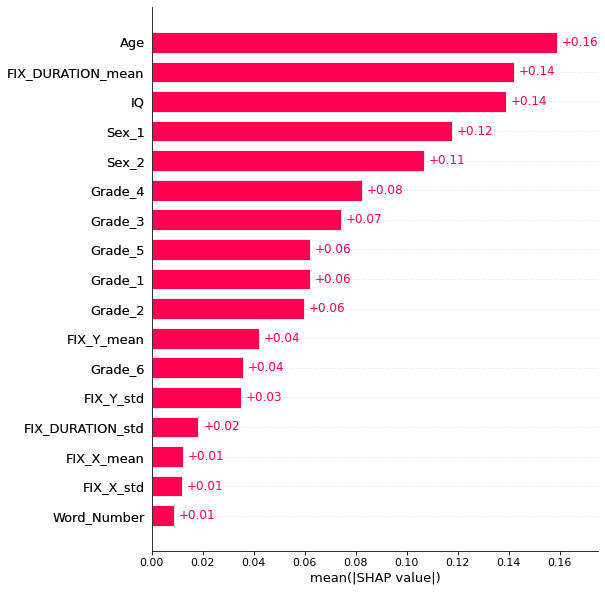

In [134]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





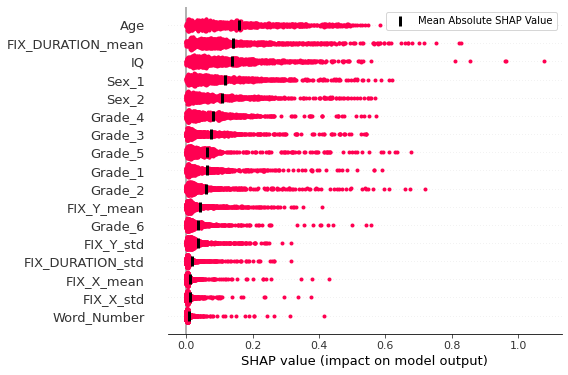

In [135]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





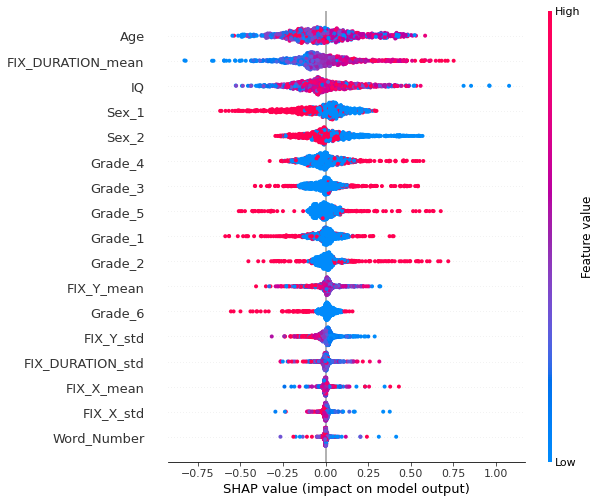

In [136]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




FixedFormatter should only be used together with FixedLocator


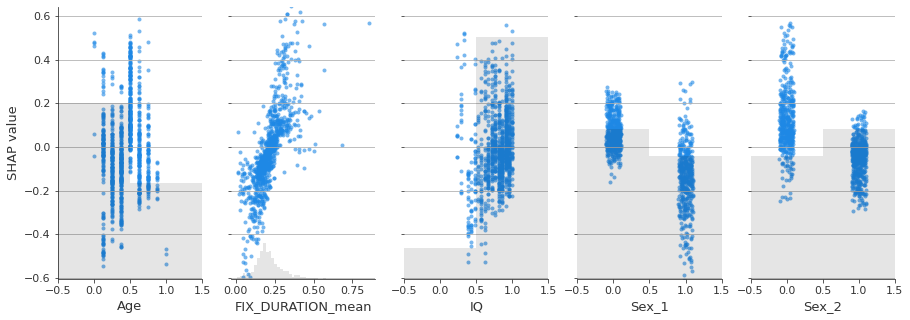

In [137]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")




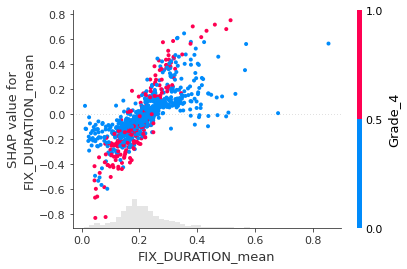

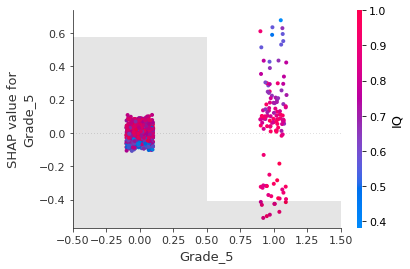

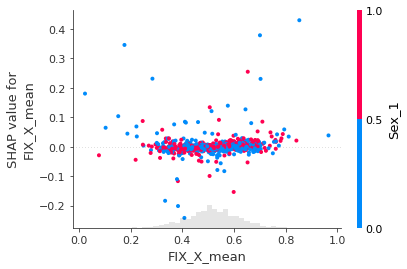

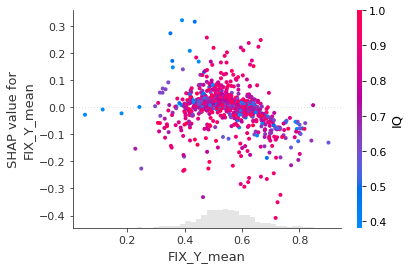

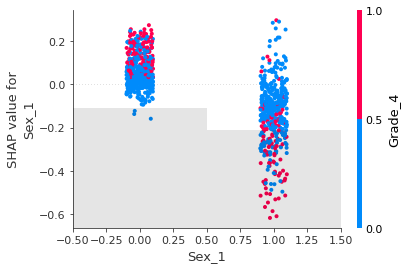

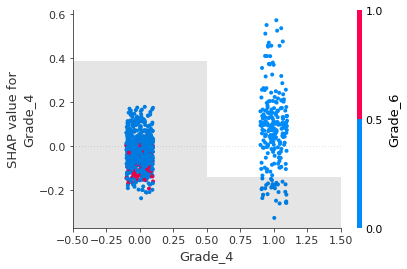

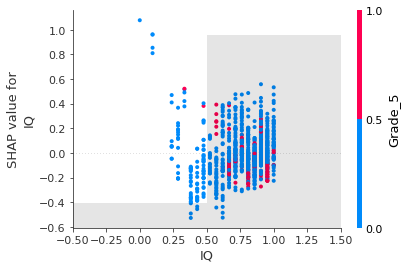

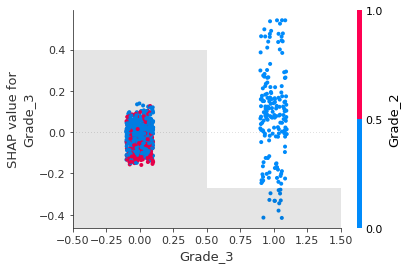

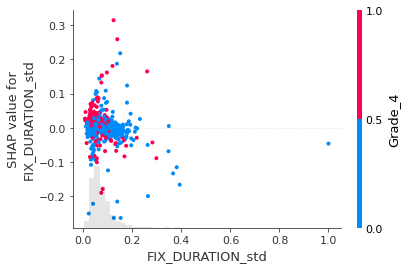

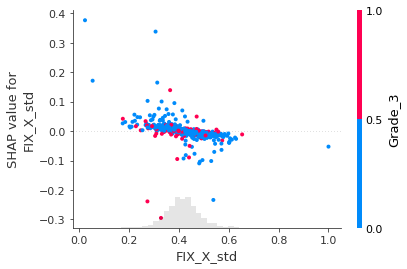

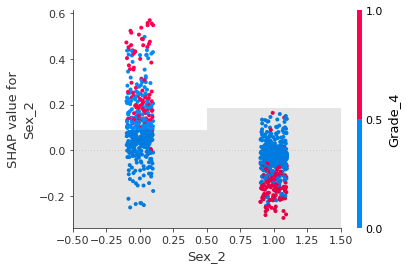

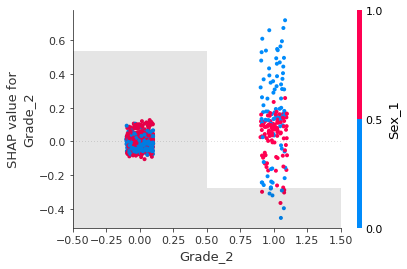

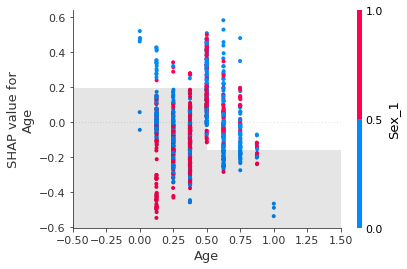

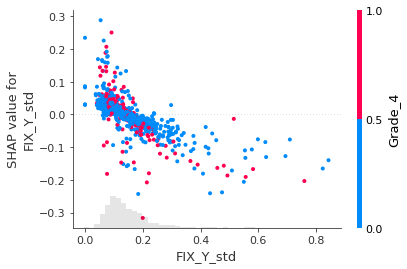

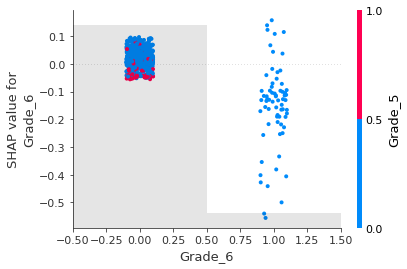

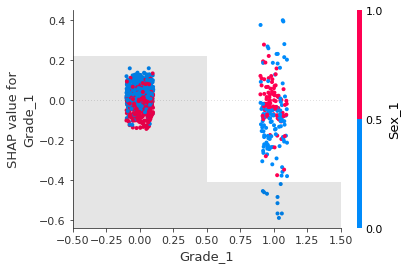

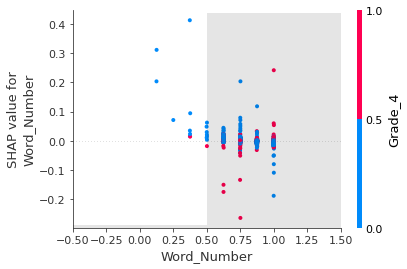

In [138]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


